- **Autor:** Alessandro Perales
- **GitHub:** https://github.com/alessandroperales74
- **Linkedin:** https://www.linkedin.com/in/alessandro-perales-cardenas/

<div style="color:white; background-color:black; padding:10px; border-radius:5px; font-size:30px;font-weight:bold;"">
    Modelo de Aprendizaje Automático: Identificación de Partidas Abiertas Vencidas para Ajuste
</div>

### Objetivo

- Se busca **identificar las partidas abiertas vencidas al cierre del periodo que deben ser ajustadas contablemente**
- Por tanto, el presente modelo es de **clasificación binaria**. Solo se busca identificar si la partida debe ser marcada para ajuste (1) o no (0)
- Se toma como base del análisis, los extornos generados por el equipo de AP en los últimos 2 años, para **identificar una posible estacionalidad**. Luego se correrá el modelo sobre el último periodo disponible, en este caso setiembre 2024, el cual no se va a utilizar para el entrenamiento, sino para las predicciones.
- Se busca minimizar el impacto de **falsos positivos**: Ajustar partidas que no corresponden
- Debido a esto último, mediremos este proceso utilizando la métrica de **Precisión (Precision)**. No obtante, se tomarán en cuenta otras métricas para identificar posibles sobreajustes del modelo

### Consideraciones

- Debido a que es data sensible, estaré omitiendo algunas partes del pre-procesamiento inicial y alguna ejecución en la que se muestra información confidencial, como un head(), por ejemplo.
- Tampoco estaré dando muchos detalles de las variables, sino que me enfocaré principalmente en la parte técnica del proceso.

# Extracción de Data

Lo que sí puedo mostrar es que la información la tengo almacenado en una Base de Datos en PostGreSQL. Los parámetros ya están previamente definidos y exportan un archivo CSV. 

Aquí también tengo el ejemplo de un query que utilizo de mis reportes que fueron extraidos previamentes de SAP.

![ConexionSQL](images/conexion_sql.jpg)

# 1. Importación de librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from time import time
from xgboost import XGBClassifier
from sklearn import tree

# 2. Lectura del DataFrame

In [2]:
# Leer archivo CSV
df = pd.read_csv('extornos\\input\\oc_vencidas.csv')

In [3]:
# Ultimo periodo que se utilizará para hacer las predicciones correspondientes
max_periodo = df['cod_periodo'].max()
max_periodo

202409

In [4]:
# Debido a que voy a realizar las pruebas sobre el periodo 202409, voy a separar los datos correspondientes en train y test original para hacer mis predicciones.
train_og = df[df['cod_periodo']!=max_periodo]
test_og = df[df['cod_periodo']==max_periodo]

In [5]:
# Separamos el código en el DataFrame que entrenamiento y de prueba
train = df[df['cod_periodo']!=max_periodo]
test = df[df['cod_periodo']==max_periodo]

# 3. Inspección de los Datos

In [6]:
# Tamaño del Dataset
train.shape

(31106, 19)

In [7]:
# Periodos cubiertos
set(train['cod_periodo'].values)

{202209,
 202210,
 202211,
 202212,
 202301,
 202302,
 202303,
 202304,
 202305,
 202306,
 202307,
 202308,
 202309,
 202310,
 202311,
 202312,
 202401,
 202402,
 202403,
 202404,
 202405,
 202406,
 202407,
 202408}

Como se puede apreciar, estamos tomando los periodos de 24 meses previos. Prefiero tomar años enteros para no introducir sesgo de un mes en particular.

In [8]:
# Validar duplicados en el dataset. Tenemos que validar que no hay duplicados por periodo, pedido y posición
train.duplicated(subset=['cod_periodo','cod_documento_compras','posicion']).sum()

0

In [9]:
# Estructura del DataFrame
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31106 entries, 5 to 165503
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   cod_periodo                  31106 non-null  int64  
 1   cod_documento_compras        31106 non-null  int64  
 2   posicion                     31106 non-null  int64  
 3   cod_proveedor                31106 non-null  object 
 4   cod_sociedad                 31106 non-null  object 
 5   cod_cuenta_mayor             31106 non-null  int64  
 6   saldo_moneda_sociedad        31106 non-null  float64
 7   fecha_contabilizacion        31106 non-null  object 
 8   cod_clase_documento          31106 non-null  object 
 9   cod_clase_documento_compras  31106 non-null  object 
 10  cod_grupo_compras            31106 non-null  object 
 11  fecha_vencimiento            31106 non-null  object 
 12  fecha_corte                  31106 non-null  object 
 13  es_vencido          

In [11]:
# Validar Datos Faltantes
train.isnull().sum()

cod_periodo                        0
cod_documento_compras              0
posicion                           0
cod_proveedor                      0
cod_sociedad                       0
cod_cuenta_mayor                   0
saldo_moneda_sociedad              0
fecha_contabilizacion              0
cod_clase_documento                0
cod_clase_documento_compras        0
cod_grupo_compras                  0
fecha_vencimiento                  0
fecha_corte                        0
es_vencido                         0
indicador_cme                  29588
extornado                          0
cod_imputacion                   526
pendientes_vim                     0
ind_criticidad                 23487
dtype: int64

In [12]:
# Para facilitar la interpretabilidad del análisis, multiplicamos el importe de las columnas numéricas por -1
train['saldo_moneda_sociedad'] = train['saldo_moneda_sociedad'] * -1
test['saldo_moneda_sociedad'] = test['saldo_moneda_sociedad'] * -1

C:\Users\aperalesc\AppData\Local\Temp\ipykernel_18892\4264420857.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['saldo_moneda_sociedad'] = train['saldo_moneda_sociedad'] * -1
C:\Users\aperalesc\AppData\Local\Temp\ipykernel_18892\4264420857.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['saldo_moneda_sociedad'] = test['saldo_moneda_sociedad'] * -1


In [13]:
# Descripción
pd.set_option('display.float_format', '{:.2f}'.format)
train.describe()

,cod_periodo,cod_documento_compras,posicion,cod_cuenta_mayor,saldo_moneda_sociedad,es_vencido,extornado,pendientes_vim,ind_criticidad
count,31106.00,31106.00,31106.00,31106.00,31106.00,31106.00,31106.00,31106.00,7619.00
mean,202303.81,4239548521.75,12.34,421101119.92,8321.11,1.00,0.33,0.00,1.00
std,68.05,46614405.95,25.20,1.80,48469.00,0.00,0.47,0.07,0.00
min,202209.00,4110000288.00,1.00,421101080.00,-1802.64,1.00,0.00,0.00,1.00
25%,202212.00,4210128134.00,1.00,421101120.00,66.60,1.00,0.00,0.00,1.00
50%,202305.00,4210194545.00,10.00,421101120.00,743.80,1.00,0.00,0.00,1.00
75%,202311.00,4300367728.00,10.00,421101120.00,3985.26,1.00,1.00,0.00,1.00
max,202408.00,4300761162.00,640.00,421101120.00,2273750.00,1.00,1.00,3.00,1.00


**Conclusiones**

- El dataset de prueba cuenta con 19 variables y 31106 registros
- Se cuenta con 9 columnas numéricas y 10 columnas categóricas del tipo nominal
- Además, se cuenta con información del periodo Agosto 2022 hasta Setiembre 2024. 24 meses anteriores al último periodo.
- Para el Dataset de prueba, solo se va a tomar hasta el periodo Agosto 2024.
- Una orden de compra puede aparecer en más de un periodo, debido a que se mide todo lo pendiente al cierre de cada periodo.
- Tomando esto en consideración, no se cuentan con duplicados por Orden de Compra, Posición y Periodo
- Tenemos datos faltantes en la columna indicador_cme y cod_imputacion
- Se puede apreciar que más del 75% de los datos de saldo_moneda_sociedad está por debajo de 3985.26 soles, cuando el máximo es de 2273750.00 soles, lo que indica **presencia de outliers**.
- En el caso de lo extornado y los pendientes_vim, más del 75% de los datos son 0, lo que habla de un **desbalance de datos en estas variables**

# 4. Pre-procesamiento de Datos

## 4.1. Feature Engineering

In [14]:
# Convertirmos la variable Imputación a una columna binaria que indique si la Orden de Compra refiere a un proyecto
train['es_capex'] = np.where(train['cod_imputacion'] == 'I', 1, 0)
test['es_capex'] = np.where(test['cod_imputacion'] == 'I', 1, 0)

# Eliminamos la primera columna del DataFrame
train = train.drop(columns=['cod_imputacion'])
test = test.drop(columns=['cod_imputacion'])

C:\Users\aperalesc\AppData\Local\Temp\ipykernel_18892\2824289798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['es_capex'] = np.where(train['cod_imputacion'] == 'I', 1, 0)
C:\Users\aperalesc\AppData\Local\Temp\ipykernel_18892\2824289798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['es_capex'] = np.where(test['cod_imputacion'] == 'I', 1, 0)


In [15]:
# Convertirmos la variable Indicador_CME a una columna binaria que indique si la Orden de Compra tiene asociado un anticip
train['tiene_anticipo'] = np.where(train['indicador_cme'] == 'A', 1, 0)
test['tiene_anticipo'] = np.where(test['indicador_cme'] == 'A', 1, 0)

# Eliminamos la primera columna del DataFrame
train = train.drop(columns=['indicador_cme'])
test = test.drop(columns=['indicador_cme'])

In [16]:
# Convertirmos la variable Indicador_CME a una columna binaria que indique si la Orden de Compra tiene asociado un anticip
train['tiene_factura_vim'] = np.where(train['pendientes_vim'] == 0, 0, 1)
test['tiene_factura_vim'] = np.where(test['pendientes_vim'] == 0, 0, 1)

# Eliminamos la primera columna del DataFrame
train = train.drop(columns=['pendientes_vim'])
test = test.drop(columns=['pendientes_vim'])

In [17]:
# Calculamos la diferencia de fechas. En teoría, mientras más diferencia haya entre la fecha de corte y la fecha de vencimiento, más probable es que se extorne una orden de compra
train['fecha_corte'] = pd.to_datetime(train['fecha_corte'])
train['fecha_vencimiento'] = pd.to_datetime(train['fecha_vencimiento'])
test['fecha_corte'] = pd.to_datetime(test['fecha_corte'])
test['fecha_vencimiento'] = pd.to_datetime(test['fecha_vencimiento'])

# Calculo de diferencia de días
train['diferencia_dias'] = (train['fecha_corte'] - train['fecha_vencimiento']).dt.days
test['diferencia_dias'] = (test['fecha_corte'] - test['fecha_vencimiento']).dt.days

# Eliminamos la columna fecha_corte del DataFrame
train = train.drop(columns=['fecha_vencimiento'])
test = test.drop(columns=['fecha_vencimiento'])

In [18]:
# Convertirmos la variable fecha_corte a una columna con solo el mes, para revisar si la estacionalidad tiene un impacto en nuestra variable
train['mes_corte'] = pd.to_datetime(train['cod_periodo'],format='%Y%m').dt.month
test['mes_corte'] = pd.to_datetime(test['cod_periodo'],format='%Y%m').dt.month

# Eliminamos la columna fecha_corte y cod_periodo del DataFrame
train = train.drop(columns=['fecha_corte'])
test = test.drop(columns=['fecha_corte'])

In [19]:
# Convertirmos la variable cod_grupo_compras a una columna binaria que indique si la Orden de Compra refiere a un grupo de compras centralizado o descentralizado
train['es_contraloria'] = np.where(train['cod_grupo_compras']=='340',1,0)
test['es_contraloria'] = np.where(test['cod_grupo_compras']=='340',1,0)

# Eliminamos la columna cod_grupo_compras del DataFrame
train = train.drop(columns=['cod_grupo_compras'])
test = test.drop(columns=['cod_grupo_compras'])

In [20]:
# Debido a que la combinación de cod_periodo, cod_documento_compras y posicion sirven como identificador único, no las vamos a considerar en el análisis. Además, vamos a eliminar fecha de contabilización.
train = train.drop(columns=['cod_periodo','cod_documento_compras','posicion'])
test = test.drop(columns=['cod_periodo','cod_documento_compras','posicion'])

In [21]:
train['es_critico'] = np.where(train['ind_criticidad']==1,1,0)
test['es_critico'] = np.where(test['ind_criticidad']==1,1,0)

In [22]:
train['es_cross'] = np.where(train['cod_proveedor'].str.startswith(('PE','EC','BO','UY','CO','CL')),1,0)
test['es_cross'] = np.where(test['cod_proveedor'].str.startswith(('PE','EC','BO','UY','CO','CL')),1,0)

In [23]:
train = train.drop(columns=['fecha_contabilizacion','ind_criticidad','cod_proveedor','cod_clase_documento','cod_cuenta_mayor','es_vencido'])
test = test.drop(columns=['fecha_contabilizacion','ind_criticidad','cod_proveedor','cod_clase_documento','cod_cuenta_mayor','es_vencido'])

# 5. Análisis Exploratorio de Datos (EDA)

## 5.1. Análisis Univariado

In [24]:
def grafico_barras(df,col):

    sns.set(rc={'figure.figsize':(8,6)})

    # Ordenar los valores de la columna de forma descendente
    ordered_col = df[col].value_counts().index

    # Crear el gráfico de barras con los valores ordenados
    ax = sns.countplot(x=col, data=train, order=ordered_col, color='skyblue')

    total = len(train[col])  # Longitud total de la columna
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)  # Calcular el porcentaje
        x = p.get_x() + p.get_width() / 2 - 0.1  # Posición en el eje x
        y = p.get_y() + p.get_height()           # Posición en el eje y
        ax.annotate(percentage, (x, y), size=14)  # Anotar el porcentaje

    plt.show()  # Mostrar el gráfico

In [25]:
def grafico_barras_binarias(df,col):

    sns.set(rc={'figure.figsize':(8,6)})
    
    # Total de Filas
    num_total = len(df[col])
    
    # Total de valores iguales a 1
    num_true = len(df[df[col]==1])

    # Total de valores iguales a 0
    num_false = len(df[df[col]==0])

    #
    plt.bar([f"Valor = 0 ({round((num_false / num_total) * 100,2)} %)", f"Valor = 1 ({round((num_true / num_total) * 100,2)} %)"],  # Etiquetas
            [num_false, num_true],  # Valores
            color=["skyblue", "salmon"],           # Colores
            width=0.8)                       # Ancho de las barras
    
    # Etiquetas del eje Y
    plt.ylabel("Total")
    
    # Mostrar gráfico
    plt.show()

### 5.1.1. Variable Objetivo - Extornado

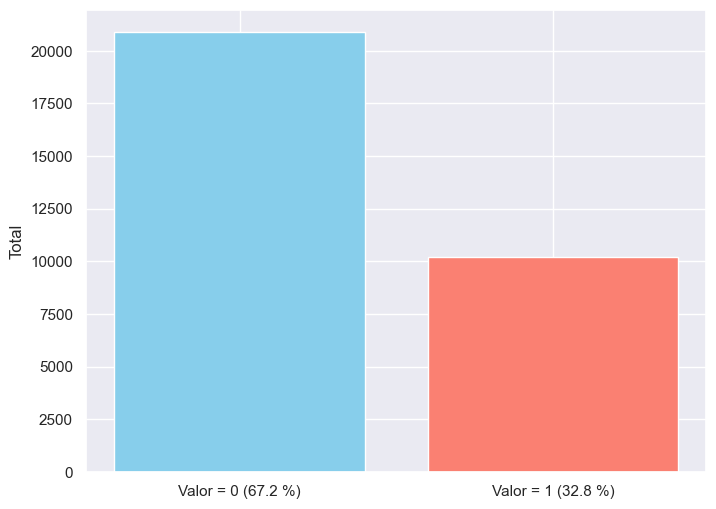

In [26]:
grafico_barras_binarias(train,'extornado')

Podemos apreciar en este análisis que nuestra variable objetivo presenta un significativo nivel de desbalance. Se recomienda aplicar alguna de las técnicas de balanceo de datos para mejorar la precisión del modelo.

### 5.1.2. Sociedad

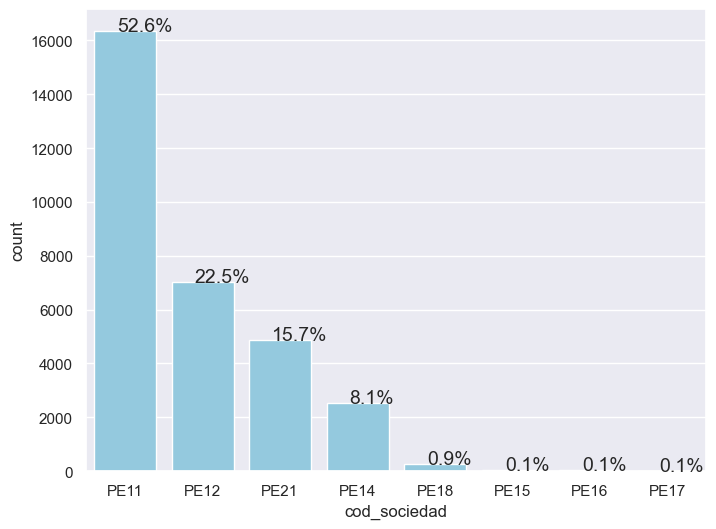

In [27]:
grafico_barras(train,'cod_sociedad')

Se puede apreciar que casi el 70% de partidas les corresponde a la sociedad PE11, lo cual se entiende por la volumetría de operaciones que maneja dicha sociedad.

### 5.1.3. Saldo Moneda Sociedad (en PEN)

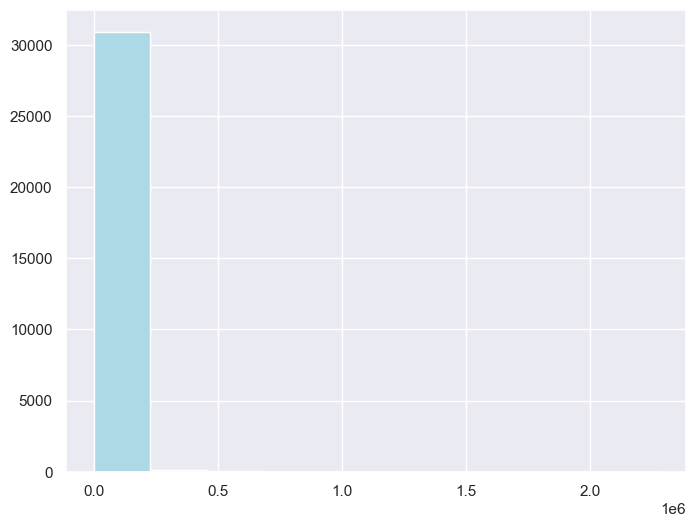

In [28]:
plt.hist(train['saldo_moneda_sociedad'],color='lightblue')
plt.show()

In [29]:
# Nivel de Kurtosis
train['saldo_moneda_sociedad'].kurt()

961.1416010677299

In [30]:
# Nivel de Asimetría
train['saldo_moneda_sociedad'].skew()

25.439186658760352

Se puede apreciar que es una distribución bimodal. Hay muchas partidas cuyo importe es menor a 1000 soles. No obstante, hay una cantidad de partidas considerable que es superior a 7000 soles. Además, la distribución está sesgada a la izquierda.

Además, el nivel de Kurtosis es cercano a 0, lo que indica que la distribución no tiene colas demasiado pesadas o ligeras. El nivel de asimetría nos indica que la distribución está sesgada hacia la izquierda.

### 5.1.4. Clase Documento de Compras

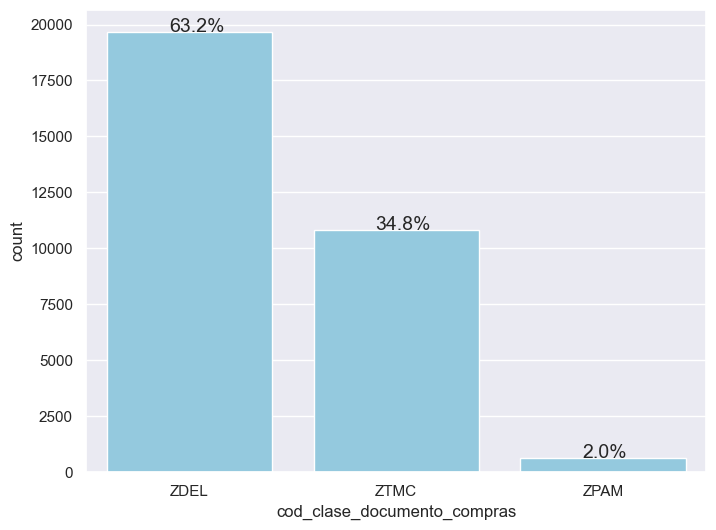

In [31]:
grafico_barras(train,'cod_clase_documento_compras')

En esta gráfica podemos apreciar que la mayoría de partidas abiertas están asociadas a pedidos ZDEL, seguido por los pedidos ZTMC

Finalmente, con un porcentaje bastante alejado de los otros dos casos, están los pedidos ZPAM

### 5.1.5. Mes Corte

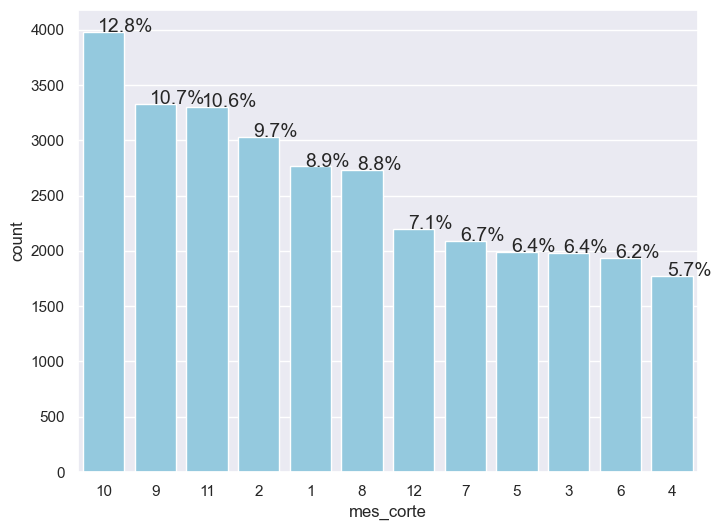

In [32]:
grafico_barras(train,'mes_corte')

Vemos que, en cuanto a la estacionalidad de los últimos 12 meses, la mayoría de partidas abiertas se han dado en los meses de setiembre y octubre. 

Además, podemos apreciar que los meses con más partidas abiertas le corresponden al segundo semestre en su mayoría (9, 10, 11, 12). Esto se puede explicar debido al aumento de volumetría que se dan para las campañas a fin de año.

### 5.1.6. Tiene Pendientes VIM

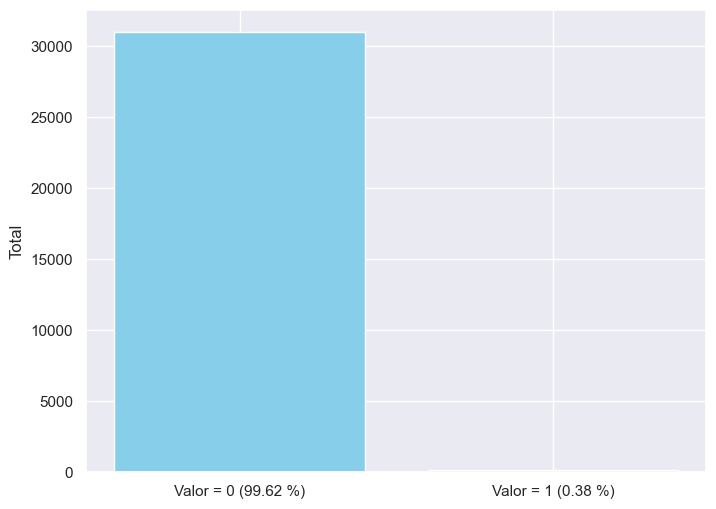

In [33]:
grafico_barras_binarias(train,'tiene_factura_vim')

Aquí podemos apreciar que solo el 0.38% de partidas abiertas tenían facturas en la bandeja de pendientes VIM que les hacían referencia al cierre del periodo. 

Si la partida tiene factura en VIM, esta no debería extornarse, ya que se encontró la factura asociada y es cuestión de registrar la partida o gestionar la observación para regularizar dicha partida

### 5.1.7. Es CAPEX

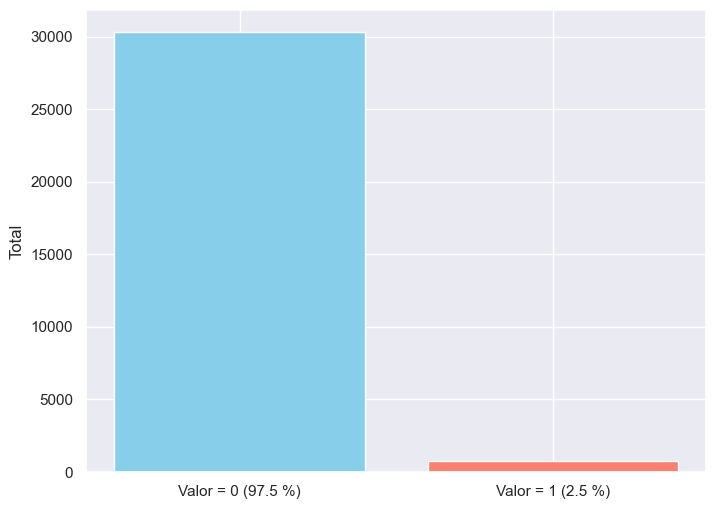

In [34]:
grafico_barras_binarias(train,'es_capex')

Se puede ver que solo el 2.12% de partidas abiertas estaban asociadas a proyectos CAPEX (imputación I). Si la partida hace referencia a una Orden de CAPEX, no debería extornarse.

### 5.1.8. Tiene Anticipo

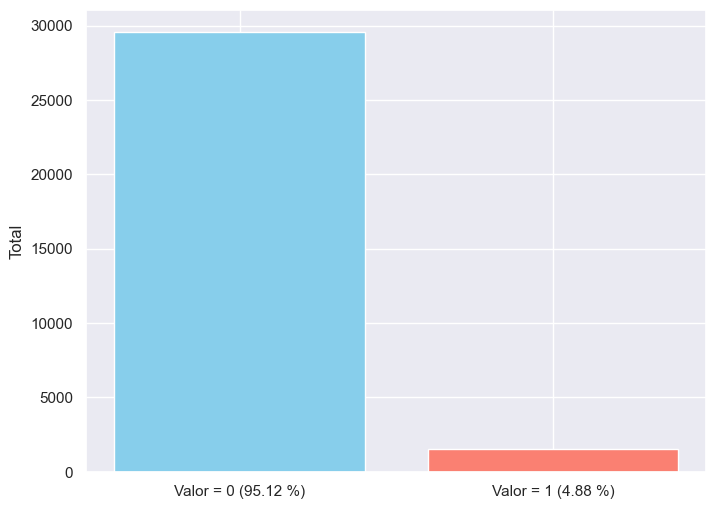

In [35]:
grafico_barras_binarias(train,'tiene_anticipo')

En este caso, solo el 4.88% de partidas abiertas contaban con anticipos asociados. Si la orden de compra está asociada a un anticipo, no debería extornarse.

### 5.1.9. Diferencia Días

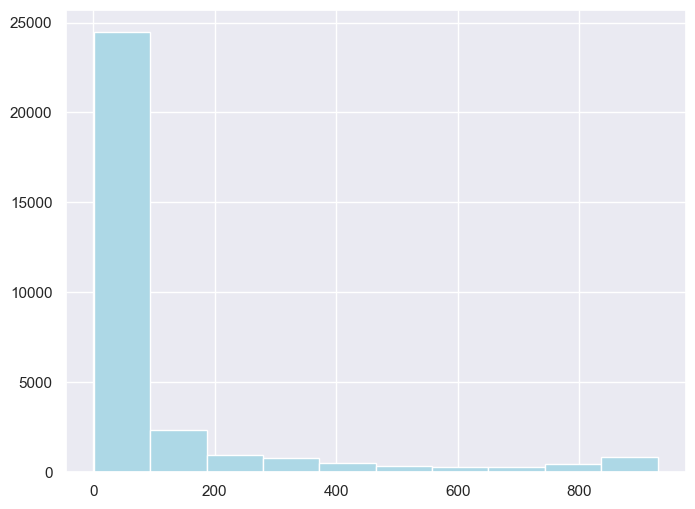

In [36]:
plt.hist(train['diferencia_dias'],color='lightblue')
plt.show()

In [37]:
# Nivel de Kurtosis
train['diferencia_dias'].kurt()

7.642994309941239

In [38]:
# Nivel de Asimetria
train['diferencia_dias'].skew()

2.8695399290333405

La distribución de diferencia de días nos indica que la gran mayoría está en un rango de 0 a 100. No obstante, se puede apreciar algunos casos de documentos de hasta 800 días, lo que podría indicar **presencia de outliers**

### 5.1.10. Es crítico

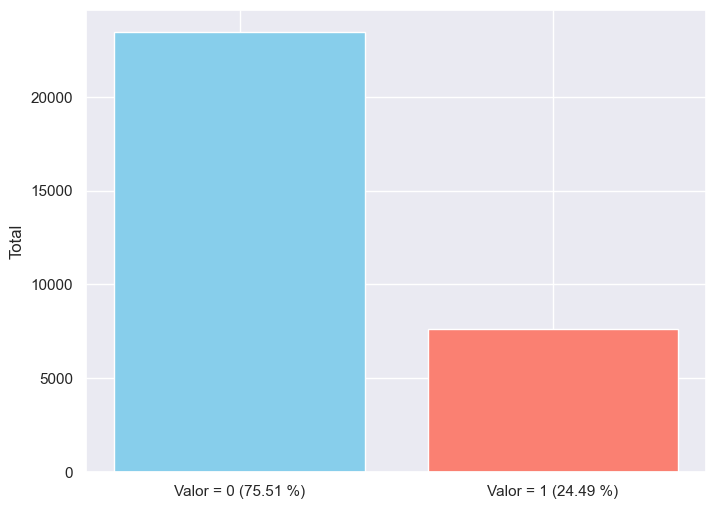

In [39]:
grafico_barras_binarias(train,'es_critico')

Solo el 2.32% de partidas abiertas le corresponden a proveedores Intercompany. En estos casos, lo ideal sería no extornar.

### 5.1.11. Es Contraloría

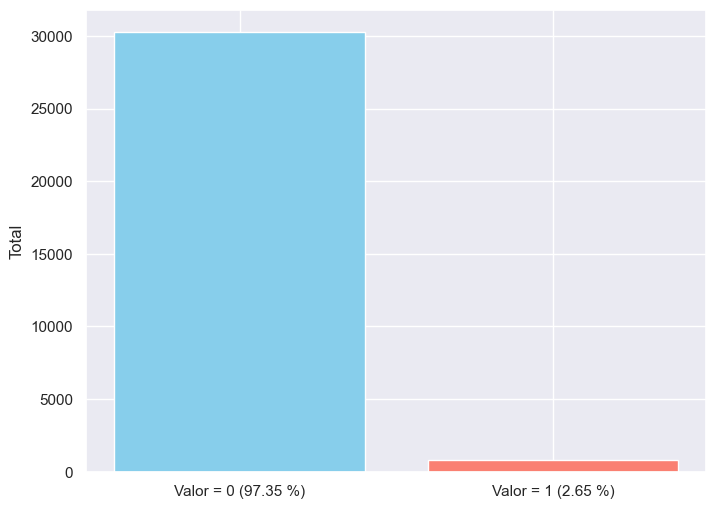

In [40]:
grafico_barras_binarias(train,'es_contraloria')

Se puede ver que solo el 2.65% de las partidas abiertas vencidas al finalizar el periodo le corresponden al Grupo de Compras de Contraloría. 

Este grupo tiene un tratamiento especial, por lo que se toma como variable.

# 5.2. Análisis Bivariado

In [41]:
### Function to plot stacked bar charts for categorical columns
def grafico_barras_bivariado(x, flag=True):
    sns.set()
    tab1 = pd.crosstab(x, train['extornado'], margins=True)
    
    if flag == True:
        print(tab1)
        print('-' * 120)
    
    tab = pd.crosstab(x, train['extornado'], normalize='index')
    
    # Cambiar la paleta de colores a skyblue y salmon
    tab.plot(kind='bar', stacked=True, figsize=(10,5), color=['lightgreen', 'salmon'])
    
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.show()

### 5.2.1. Sociedad

extornado      0.00   1.00    All
cod_sociedad                     
PE11          11264   5084  16348
PE12           4029   2978   7007
PE14           1979    550   2529
PE15             32      5     37
PE16             20      3     23
PE17             10      6     16
PE18            199     69    268
PE21           3370   1508   4878
All           20903  10203  31106
------------------------------------------------------------------------------------------------------------------------


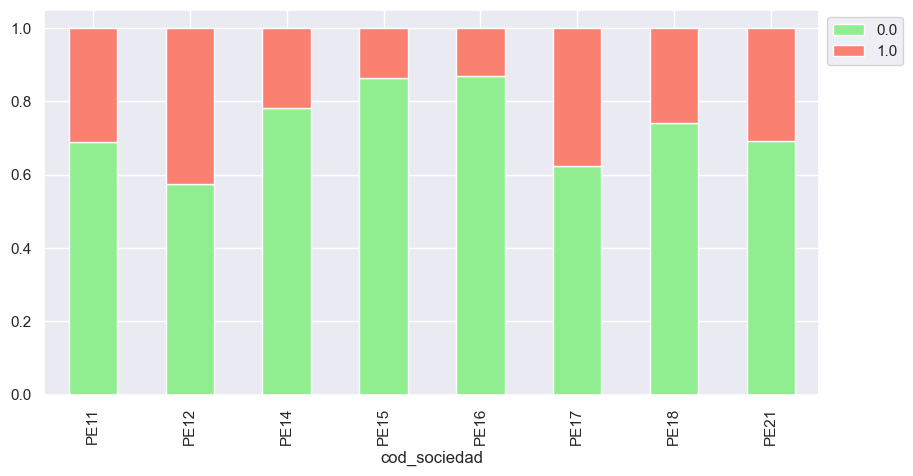

In [42]:
grafico_barras_bivariado(train.cod_sociedad)

En el ánálisis bivariado se nos indica que, a pesar de que PE11 es la sociedad con más volumen de partidas abiertas, las sociedades PE12 y PE21 tienen más partidas extornadas en promedio. Por otro lado, las sociedades PE16 y PE17, al ser sociedades con muy bajo nivel de volumetría, no suelen presentarse estos casos de partidas abiertas vencidas o extornos.

### 5.2.2. Clase Documento de Compras

extornado                     0.00   1.00    All
cod_clase_documento_compras                     
ZDEL                         15662   4007  19669
ZPAM                           478    145    623
ZTMC                          4763   6051  10814
All                          20903  10203  31106
------------------------------------------------------------------------------------------------------------------------


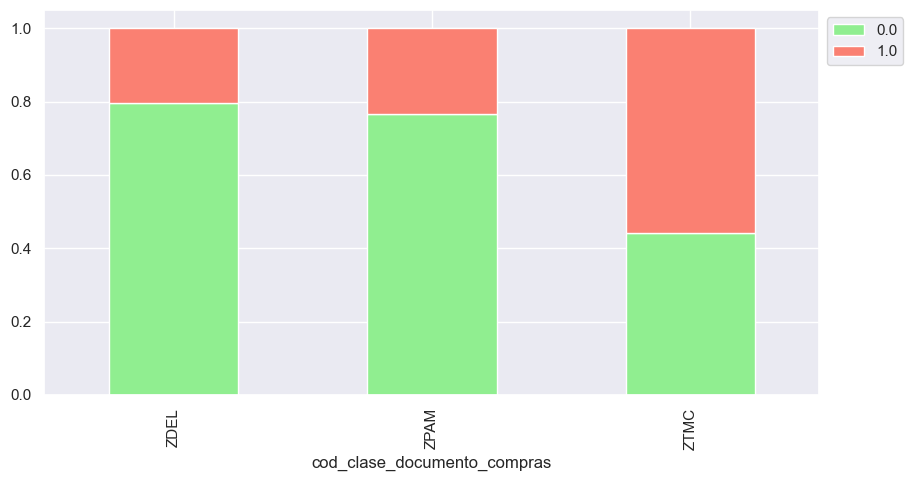

In [43]:
grafico_barras_bivariado(train.cod_clase_documento_compras)

Las ordenes de compras que más se extornan son las de ZTMC. Además, vemos que, a pesar de que ZPAM sea solo el 4% del total, se extorna más en proporción que el ZDEL, que representa el 67% del total.

### 5.2.3. Tiene Pendientes VIM

extornado           0.00   1.00    All
tiene_factura_vim                     
0                  20788  10201  30989
1                    115      2    117
All                20903  10203  31106
------------------------------------------------------------------------------------------------------------------------


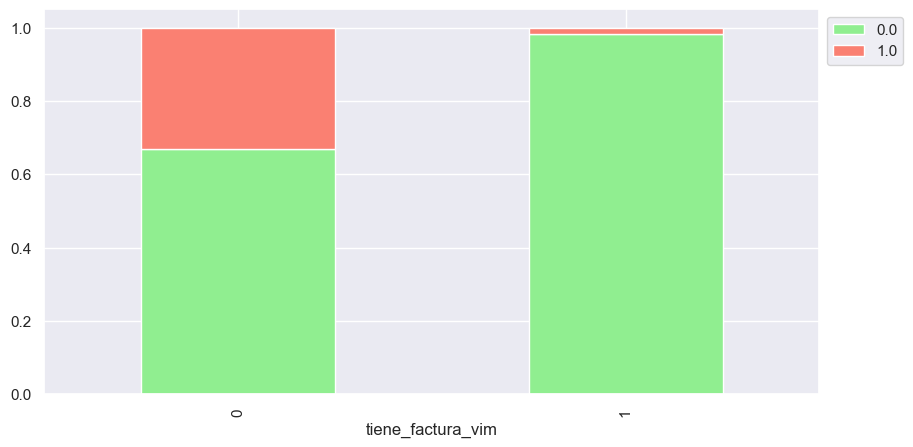

In [44]:
grafico_barras_bivariado(train.tiene_factura_vim)

De esta gráfica se infiere que, si la orden de compra tiene una factura asociada en la bandeja de pendientes, no se suele extornar. 

Por otro lado, si la partida está vencida y tampoco está en la bandeja de pendientes VIM, es más probable que se extorne.

### 5.2.4. Es Capex

extornado   0.00   1.00    All
es_capex                      
0          20188  10141  30329
1            715     62    777
All        20903  10203  31106
------------------------------------------------------------------------------------------------------------------------


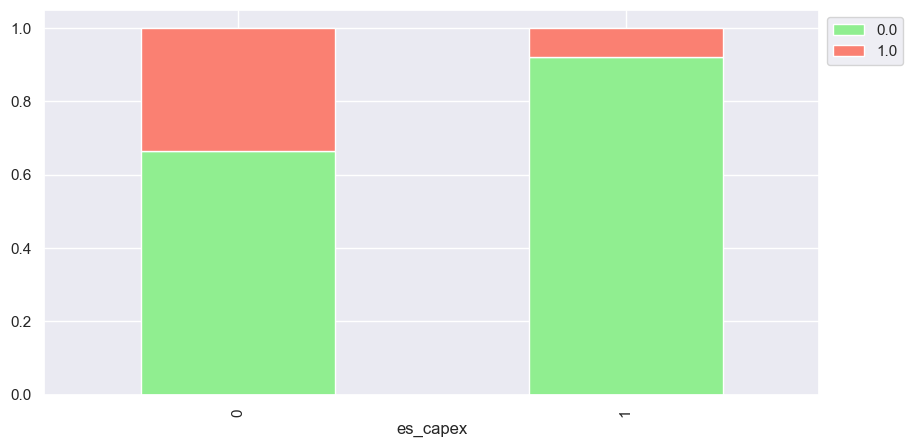

In [45]:
grafico_barras_bivariado(train.es_capex)

En el caso de las ordenes de compra de Capex, se puede ver que es menos probable que se extorne una partida si esta le corresponde a una orden de compra de CAPEX.

### 5.2.5. Tiene anticipo

extornado        0.00   1.00    All
tiene_anticipo                     
0               19408  10180  29588
1                1495     23   1518
All             20903  10203  31106
------------------------------------------------------------------------------------------------------------------------


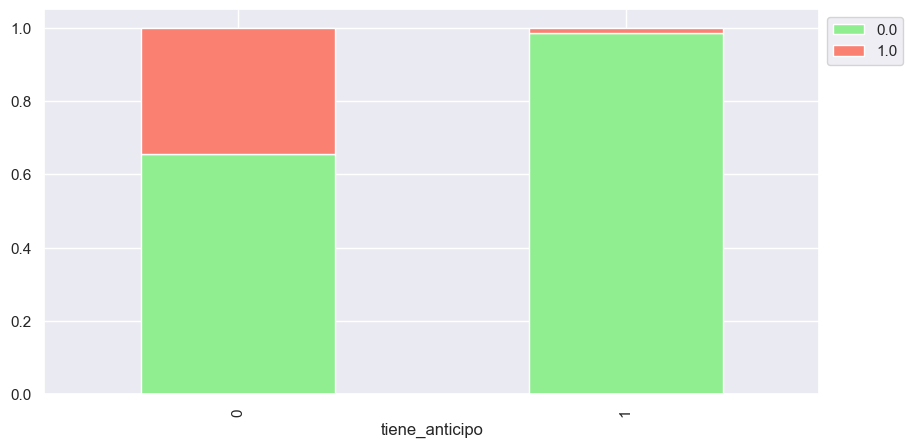

In [46]:
grafico_barras_bivariado(train.tiene_anticipo)

En el caso de las ordenes de compra con anticipos, se puede ver que casi no se extornan partidas que tengan anticipos. Eso debido a que son necesarias para regularizar el anticipo, por lo que si se extorna, complica el proceso de regularización.

### 5.2.6. Mes corte

extornado   0.00   1.00    All
mes_corte                     
1           2207    557   2764
2           1400   1632   3032
3            979   1001   1980
4           1167    605   1772
5           1245    746   1991
6           1269    666   1935
7           1693    398   2091
8           1769    962   2731
9           2871    457   3328
10          2440   1541   3981
11          1951   1351   3302
12          1912    287   2199
All        20903  10203  31106
------------------------------------------------------------------------------------------------------------------------


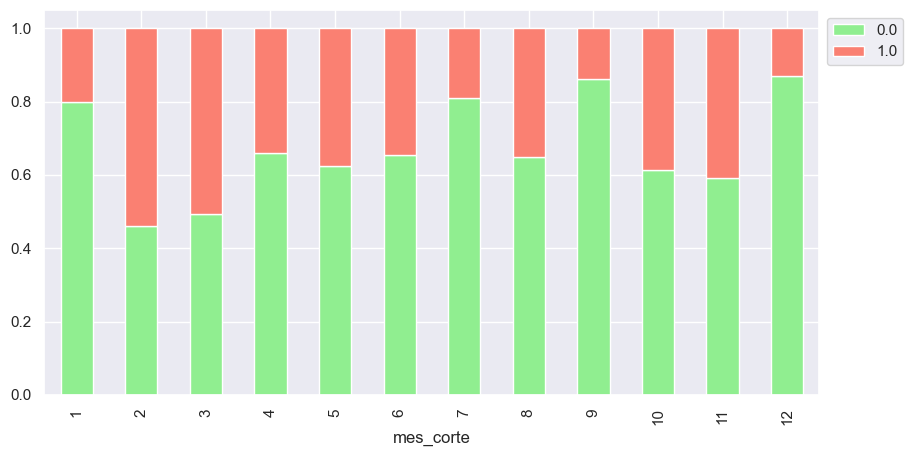

In [47]:
grafico_barras_bivariado(train.mes_corte)

Vemos que hay una disminución de extornos en los meses de diciembre y enero. Esto debido a que se prefiere evitar extornar partidas en estos meses. 

Usualmente, estos extornos terminan regularizándose a partir de febrero en adelante.

### 5.2.7. Es Cross

extornado   0.00   1.00    All
es_cross                      
0          20211  10173  30384
1            692     30    722
All        20903  10203  31106
------------------------------------------------------------------------------------------------------------------------


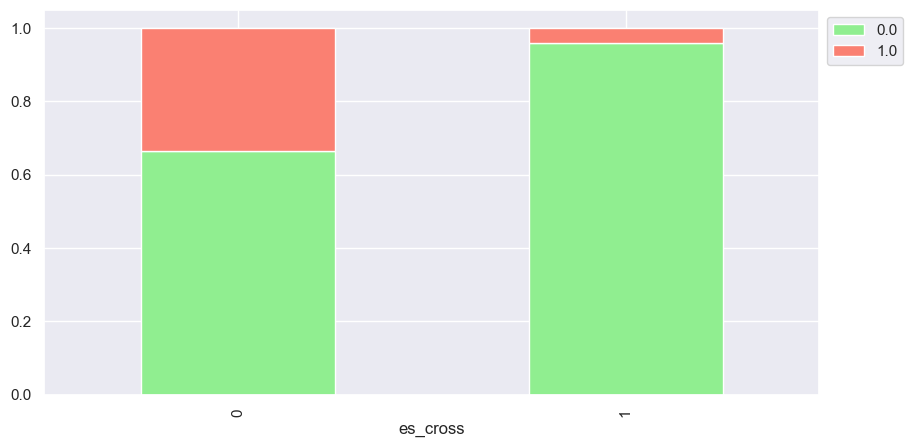

In [48]:
grafico_barras_bivariado(train.es_cross)

De acuerdo a la gráfica, vemos que es mucho menos probable que se extornen partidas relacionadas a proveedores cross company

### 5.2.6. Es Contraloria

extornado        0.00   1.00    All
es_contraloria                     
0               20139  10142  30281
1                 764     61    825
All             20903  10203  31106
------------------------------------------------------------------------------------------------------------------------


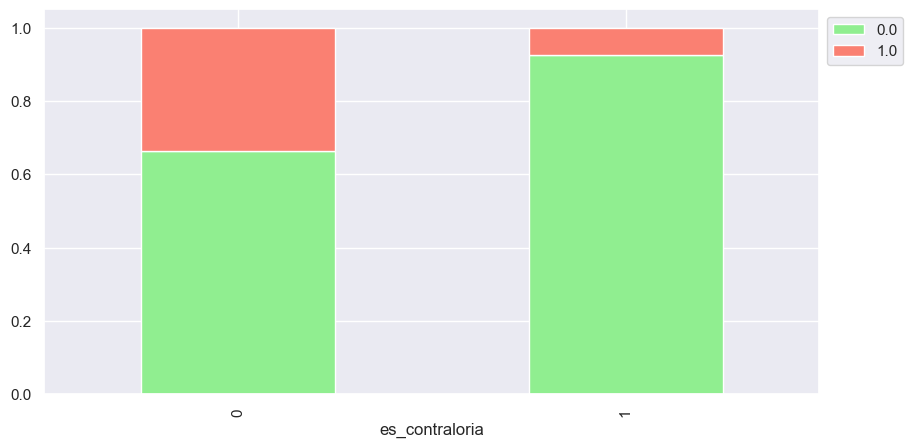

In [49]:
grafico_barras_bivariado(train.es_contraloria)

Asimismo, vemos que es mucho menos probable que se extornen partidas relacionadas a proveedores del grupo de compras de Contraloría.

## 5.3. Tratamiento de Outliers

En esta parte del análisis, revisamos si hay outliers dentro de las variables numéricas que consideramos relevantes para el análisis

- saldo_moneda_sociedad
- diferencia_dias

In [50]:
def tratar_outliers(df,col):

    Q1=df[col].quantile(0.25) # 25th quantile
    Q3=df[col].quantile(0.75)  # 75th quantile
    IQR=Q3-Q1

    # Para este métrica vamos a utilizar el 1.5 del Rango Intercuartil
    Lower_Whisker = Q1 - 1.5*IQR
    Upper_Whisker = Q3 + 1.5*IQR
    df[col] = np.clip(df[col], Lower_Whisker, Upper_Whisker)

    return df


### 5.3.1. Saldo Moneda Sociedad

<Axes: xlabel='saldo_moneda_sociedad'>

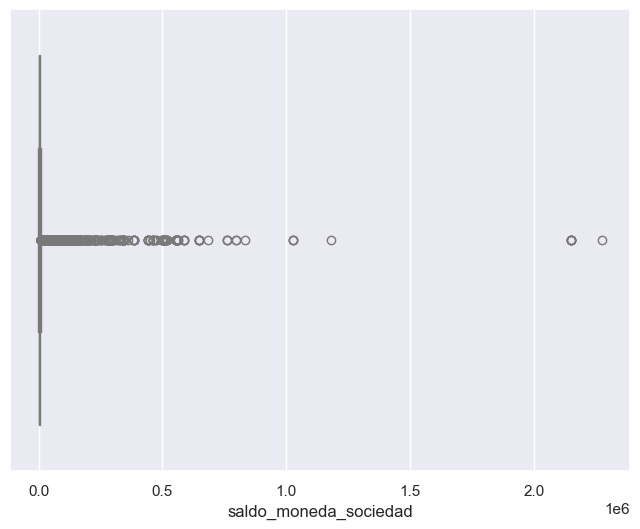

In [51]:
# Gráfica de cajas
sns.boxplot(x=train['saldo_moneda_sociedad'],color='lightblue')

Vemos que en el boxplot vemos outliers muy alejados de los whiskers. Va a ser necesario aplicar una función para regularizar esta columna.

In [52]:
train = tratar_outliers(train,'saldo_moneda_sociedad')
test = tratar_outliers(test,'saldo_moneda_sociedad')

<Axes: xlabel='saldo_moneda_sociedad'>

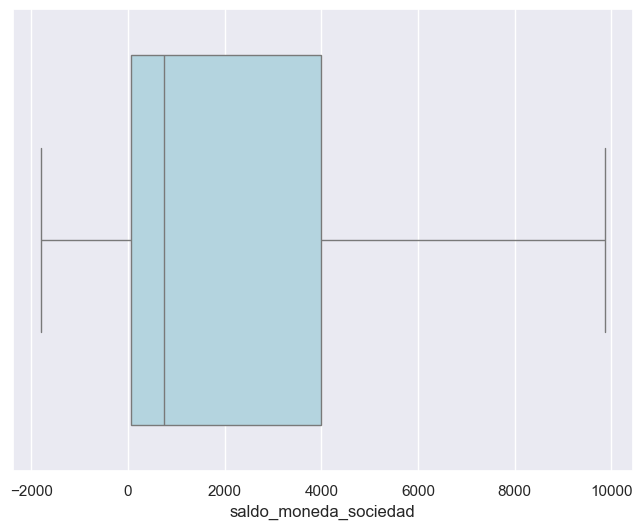

In [53]:
# Boxplot posterior al tratamiento de Outliers
sns.boxplot(x=train['saldo_moneda_sociedad'],color='lightblue')

Después del ajuste de Outliers vemos que no se presentan outliers en el Boxplot.

### 5.3.2. Diferencia Dias

<Axes: xlabel='diferencia_dias'>

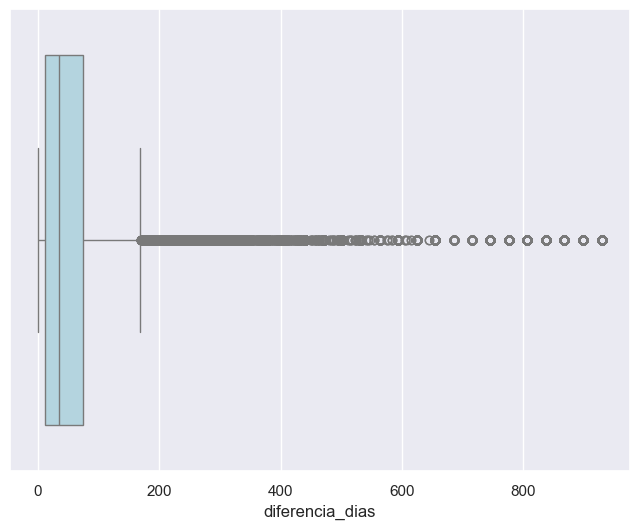

In [54]:
# Gráfica de cajas
sns.boxplot(x=train['diferencia_dias'],color='lightblue')

En este boxplot tambien vemos que hay outliers muy alejados de los whiskers. Vamos a aplicar la misma función para regularizar esta columna.

In [55]:
train = tratar_outliers(train,'diferencia_dias')
test = tratar_outliers(test,'diferencia_dias')

<Axes: xlabel='diferencia_dias'>

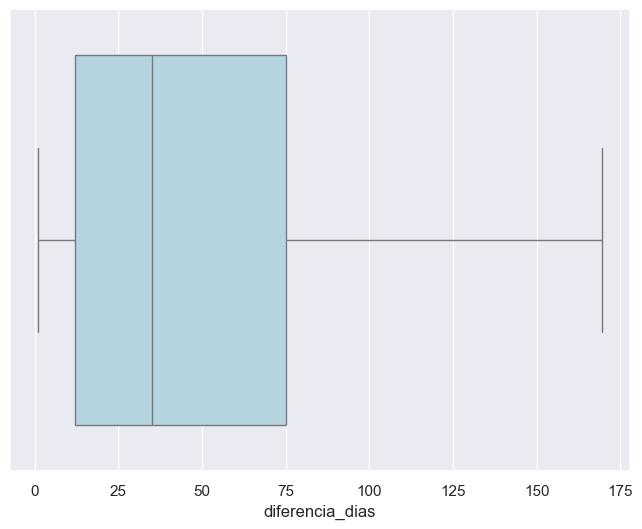

In [56]:
# Boxplot posterior al tratamiento de Outliers
sns.boxplot(x=train['diferencia_dias'],color='lightblue')

### 5.4. Tratamiento de Variables Categóricas

In [57]:
# Convertir variables categóricas a numéricas usando One-Hot Encoding
train_dummies = pd.get_dummies(train, columns=['cod_clase_documento_compras', 'cod_sociedad','mes_corte'])
test_dummies = pd.get_dummies(test, columns=['cod_clase_documento_compras', 'cod_sociedad','mes_corte'])

In [58]:
train_dummies.isnull().sum()

saldo_moneda_sociedad               0
extornado                           0
es_capex                            0
tiene_anticipo                      0
tiene_factura_vim                   0
diferencia_dias                     0
es_contraloria                      0
es_critico                          0
es_cross                            0
cod_clase_documento_compras_ZDEL    0
cod_clase_documento_compras_ZPAM    0
cod_clase_documento_compras_ZTMC    0
cod_sociedad_PE11                   0
cod_sociedad_PE12                   0
cod_sociedad_PE14                   0
cod_sociedad_PE15                   0
cod_sociedad_PE16                   0
cod_sociedad_PE17                   0
cod_sociedad_PE18                   0
cod_sociedad_PE21                   0
mes_corte_1                         0
mes_corte_2                         0
mes_corte_3                         0
mes_corte_4                         0
mes_corte_5                         0
mes_corte_6                         0
mes_corte_7 

Se puede apreciar que no hay valores faltantes en el dataset de prueba

In [59]:
test_dummies.isnull().sum()

saldo_moneda_sociedad               0
extornado                           0
es_capex                            0
tiene_anticipo                      0
tiene_factura_vim                   0
diferencia_dias                     0
es_contraloria                      0
es_critico                          0
es_cross                            0
cod_clase_documento_compras_ZDEL    0
cod_clase_documento_compras_ZPAM    0
cod_clase_documento_compras_ZTMC    0
cod_sociedad_PE11                   0
cod_sociedad_PE12                   0
cod_sociedad_PE14                   0
cod_sociedad_PE16                   0
cod_sociedad_PE21                   0
mes_corte_9                         0
dtype: int64

Aquí vemos que no todas las columnas del train no están en el Test Dummies. Debido a que es un One-Hot encoding, los valores que no están en las columnas deberían ser 0. Por lo tanto, haremos una función para añadir las columnas faltantes al dataframe de prueba con valor igual a 0

In [60]:
for col in train_dummies.columns:
    if col not in test_dummies.columns:
        # Si la columna no está en test_dummies, la agregamos con valores 0
        test_dummies[col] = 0

In [61]:
# Eliminar columna variable objetivo
train_dummies.drop(columns=['extornado'])

,saldo_moneda_sociedad,es_capex,tiene_anticipo,tiene_factura_vim,diferencia_dias,es_contraloria,es_critico,es_cross,cod_clase_documento_compras_ZDEL,cod_clase_documento_compras_ZPAM,...,mes_corte_3,mes_corte_4,mes_corte_5,mes_corte_6,mes_corte_7,mes_corte_8,mes_corte_9,mes_corte_10,mes_corte_11,mes_corte_12
5,1789.00,0,0,0,91.00,0,0,0,False,True,...,False,False,False,False,False,False,True,False,False,False
10,71.88,0,0,0,126.00,0,0,0,False,True,...,False,False,False,False,False,False,True,False,False,False
11,1623.67,0,0,0,103.00,0,0,0,False,True,...,False,False,False,False,False,False,True,False,False,False
12,1623.67,0,0,0,103.00,0,0,0,False,True,...,False,False,False,False,False,False,True,False,False,False
13,15.88,0,0,0,102.00,0,0,0,False,True,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165499,60.04,0,0,0,2.00,0,1,0,False,False,...,False,False,False,False,False,True,False,False,False,False
165500,60.05,0,0,0,2.00,0,1,0,False,False,...,False,False,False,False,False,True,False,False,False,False
165501,60.05,0,0,0,2.00,0,1,0,False,False,...,False,False,False,False,False,True,False,False,False,False
165502,375.29,0,0,0,2.00,0,0,0,False,False,...,False,False,False,False,False,True,False,False,False,False


### 5.5. Matriz de Correlación

<Axes: >

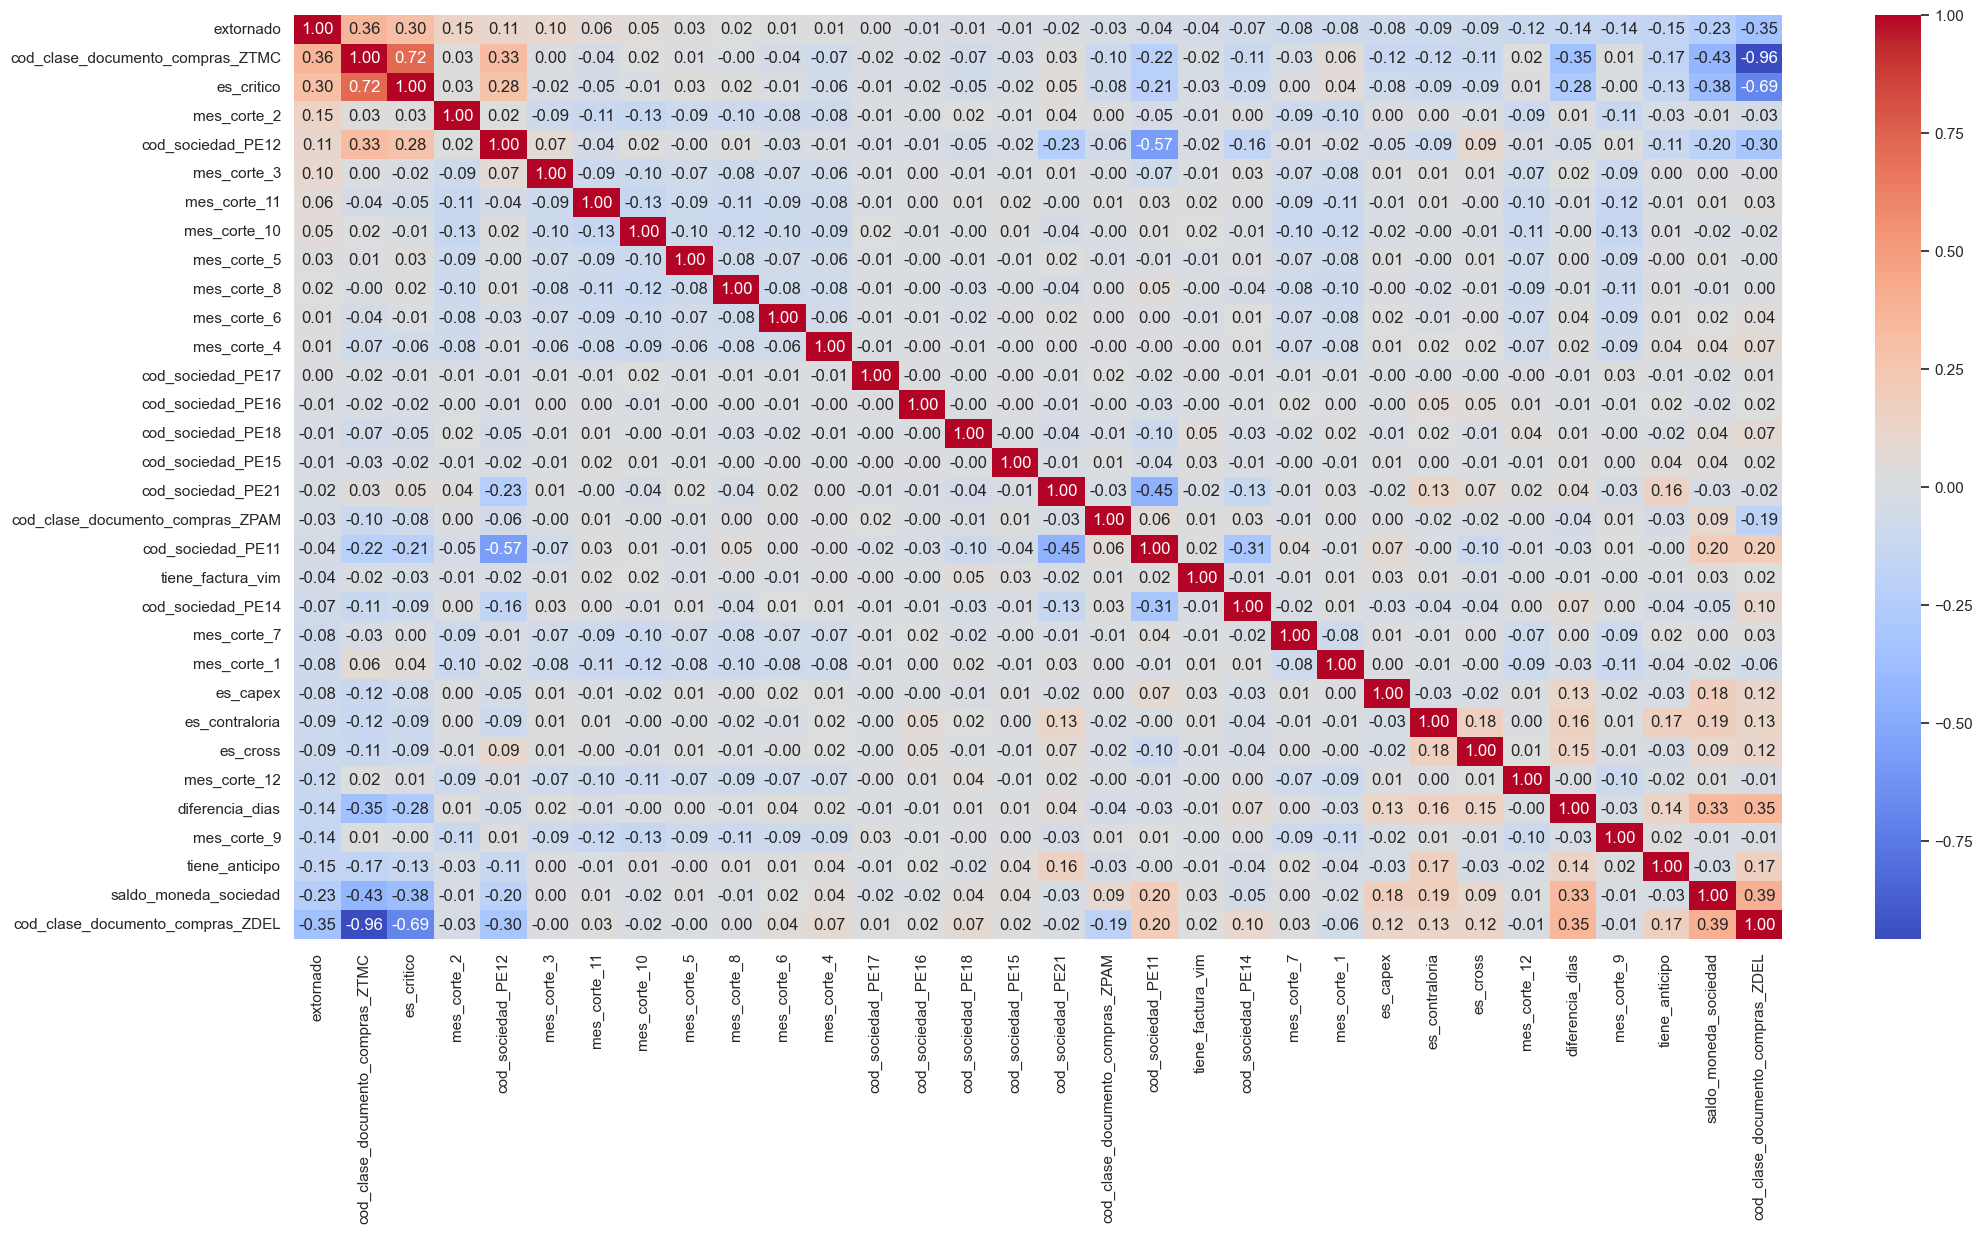

In [62]:
# Usamos la función corrwith para hacer una matriz de correlación
corr = train_dummies.corrwith(train_dummies['extornado'],numeric_only=True).sort_values(ascending=False).index.to_list()

# Generar matriz de correlación
corr_matrix = train_dummies[corr].corr(numeric_only=True)

# Generamos la matriz de correlación
plt.figure(figsize=(24,12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")

### Conclusiones

De acuerdo a la matriz de correlación, podemos concluir lo siguiente.

- Es mucho más probable que se extorne una partida de exportaciones (que tiene una correlación de 0.36) que una partida de Servicios (con una correlación negativa de -0.35)
- La criticidad del proveedor no suele ser relevante para extornar partidas de exportaciones, lo que se ve reflejado en su correlación fuerte con la clase de documento ZTMC (0.72)
- Es más probable que el mes 2 (febrero) se terminen extornando partidas, a diferencia del mes 12.
- A mayor importe en moneda sociedad, menos probable es que se extorne (según la correlación negativa de -0.23)
- Si la partida es de Capex, Cross o Contraloría, es menos probable que se extorne.
- Las sociedades no suelen tener impacto relevante en la decisión de extornar una partida.

# 6. Entrenamiento del Modelo

## 6.1. Tratamiento del Desbalance de Datos

Antes de entrenar el modelo, tenemos que mapear el tema del desbalance de datos de nuestra variable objetivo. Para evitar la pérdida de datos, vamos a probar la técnica de **sobremuestreo (oversampling)** y de **submuestro (undersampling)**

In [63]:
# Separamos el Dataframe en dos, los extornados y los no extornados
train_extornados = train_dummies[train_dummies['extornado']==1]
train_no_extornados = train_dummies[train_dummies['extornado']==0]

# Validamos los números
print(f'Extornados en Data de Entrenamiento: {len(train_extornados)}')
print(f'No Extornados en Data de Entrenamiento: {len(train_no_extornados)}')

Extornados en Data de Entrenamiento: 10203
No Extornados en Data de Entrenamiento: 20903


In [64]:
# Como vimos anteriormente, hay un desbalance considerable entre ambos
train_ext_sobremuestreo = train_extornados.sample(n=len(train_no_extornados), replace=True, random_state=0)

# Validamos el número
print(f'Extornados en Data con Sobremuestreo: {len(train_ext_sobremuestreo)}')

Extornados en Data con Sobremuestreo: 20903


In [65]:
# Ahora probamos con submuestreo
train_no_ext_submuestreo = train_no_extornados.sample(n=len(train_extornados), replace=True, random_state=0)

# Validamos el número
print(f'No extornados en Data con Submuestreo: {len(train_no_ext_submuestreo)}')

No extornados en Data con Submuestreo: 10203


In [66]:
# Creamos los dos dataframes
train_submuestreo = pd.concat([train_extornados,train_no_ext_submuestreo])
train_sobremuestreo = pd.concat([train_no_extornados,train_ext_sobremuestreo])

print(f'Filas en Dataframe original: {len(train_dummies)}')
print(f'Filas en Dataframe de Submuestreo: {len(train_submuestreo)}')
print(f'Filas en Dataframe de Sobremuestreo: {len(train_sobremuestreo)}')

Filas en Dataframe original: 31106
Filas en Dataframe de Submuestreo: 20406
Filas en Dataframe de Sobremuestreo: 41806


## 6.2. Entrenamiento de Modelos

In [67]:
df_metrics = pd.DataFrame(columns=['Model','Accuracy_train', 'Accuracy_test', 'Recall_train', 'Recall_test', 'Precision_train', 'Precision_test','CV_Mean_Score','Time_Sec','Time_Min'])

In [68]:
pd.reset_option('display.float_format')

In [69]:
def obtener_metricas(nombre_modelo, model, inicio, final, flag=True):
    
    # Variables globales
    global df_metrics

    # Definiendo listas vacías para almacenar los resultados
    score_list = []

    # Validación cruzada
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # Cambia el número de folds según sea necesario

    # Predicciones en el conjunto de entrenamiento y prueba
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    train_recall = metrics.recall_score(y_train, pred_train)
    test_recall = metrics.recall_score(y_test, pred_test)

    train_precision = metrics.precision_score(y_train, pred_train)
    test_precision = metrics.precision_score(y_test, pred_test)

    score_list.extend((train_acc, test_acc, train_recall, test_recall, train_precision, test_precision))

    time_sec = round(final - inicio, 2)
    time_min = round(time_sec / 60, 2)

    # Si el flag está configurado como True, imprimir resultados
    if flag:
        print("Exactitud (Accuracy) en dataset de entrenamiento : ", train_acc)
        print("Exactitud (Accuracy) en dataset de prueba : ", test_acc)
        print("Sensibilidad (Recall) en dataset de entrenamiento : ", train_recall)
        print("Sensibilidad (Recall) en dataset de prueba : ", test_recall)
        print("Precisión (Precision) en dataset de entrenamiento : ", train_precision)
        print("Precisión (Precision) en dataset de prueba : ", test_precision)
        print("Promedio de Validación Cruzada : ", cv_scores.mean())  # Mostrar la media de la validación cruzada
        print("Tiempo de cómputo (en segundos) : ", time_sec)
        print("Tiempo de cómputo (en minutos) : ", time_min)
        
    new_metrics = {
        'Model': nombre_modelo,
        'Accuracy_train': train_acc,
        'Accuracy_test': test_acc,
        'Recall_train': train_recall,
        'Recall_test': test_recall,
        'Precision_train': train_precision,
        'Precision_test': test_precision,
        'CV_Mean_Score': cv_scores.mean(),  # Media de validación cruzada
        'Time_Sec': time_sec,
        'Time_Min': time_min
    }

    temp_df = pd.DataFrame([new_metrics])

    # Reemplazamos el valor si es que ya hemos anexado previamente el mismo modelo
    if len(df_metrics[df_metrics['Model']==nombre_modelo]) != 0:
        df_metrics = df_metrics[df_metrics['Model']!=nombre_modelo]
    
    df_metrics = pd.concat([df_metrics, temp_df], ignore_index=True)

    return score_list

In [70]:
## Function to create confusion matrix
def matriz_de_confusion(model, y_actual, labels=[1, 0]):

    y_predict = model.predict(X_test)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])

    # Crear DataFrame para la matriz de confusión
    df_cm = pd.DataFrame(cm, index=["Real - No", "Real - Yes"],
                         columns=['Predicted - No', 'Predicted - Yes'])

    # Crear etiquetas para mostrar valores y porcentajes
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Colores para los verdaderos y falsos
    cmap = np.array([['#FF6347', '#FF6347'],  # Rojo para FP y FN
                     ['#32CD32', '#32CD32']])  # Verde para TP y TN

    plt.figure(figsize=(10, 7))

    # Usamos sns.heatmap con los colores específicos
    sns.heatmap(df_cm, annot=labels, fmt='', cmap=sns.color_palette(cmap.flatten()), cbar=False)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### 6.2.1. División entre Data de Entrenamiento y Data de Prueba

In [71]:
# Dividir los datos en X (variables predictoras) e y (variable objetivo)
X = train_sobremuestreo.drop(['extornado'], axis=1)  # Variables independientes
y = train_sobremuestreo['extornado']  # Variable dependiente (target)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 6.3. Entrenamiento de Modelos

#### 6.3.1. Regresión logística

C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mode

Exactitud (Accuracy) en dataset de entrenamiento :  0.7277884089666484
Exactitud (Accuracy) en dataset de prueba :  0.7268378249083081
Sensibilidad (Recall) en dataset de entrenamiento :  0.7321257689678742
Sensibilidad (Recall) en dataset de prueba :  0.7262872628726287
Precisión (Precision) en dataset de entrenamiento :  0.7257758503862312
Precisión (Precision) en dataset de prueba :  0.7272146847565842
Promedio de Validación Cruzada :  0.7270367510500776
Tiempo de cómputo (en segundos) :  1.59
Tiempo de cómputo (en minutos) :  0.03


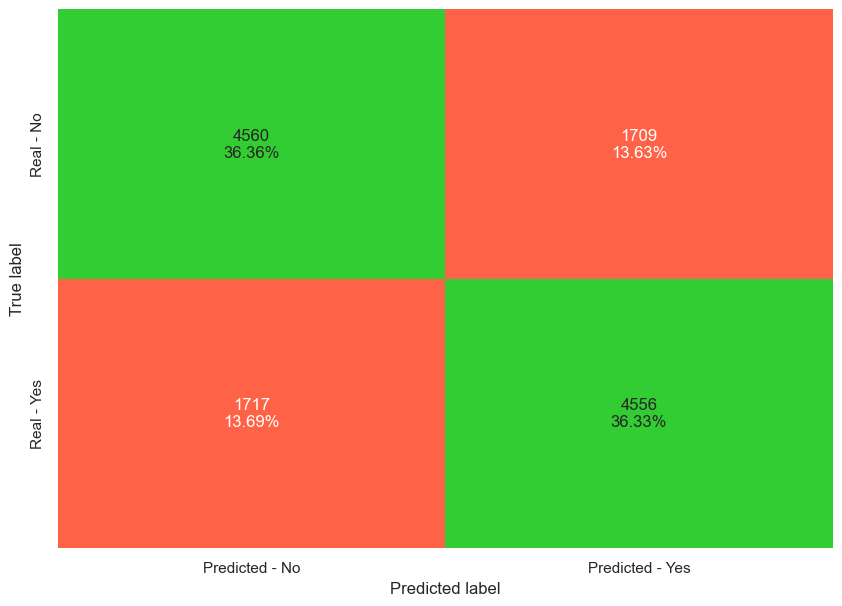

In [72]:
# Instanciar el modelo de regresión logística
lr = LogisticRegression(max_iter=1000)

inicio_lr = time()

# Entrenar el modelo
lr.fit(X_train, y_train)

final_lr = time()

#Calculating different metrics
obtener_metricas('Regresión Logística',lr,inicio_lr,final_lr)

#Creating confusion matrix
matriz_de_confusion(lr,y_test)

#### 6.3.2. Decision Tree

Exactitud (Accuracy) en dataset de entrenamiento :  0.9937465828321487
Exactitud (Accuracy) en dataset de prueba :  0.9332642321798756
Sensibilidad (Recall) en dataset de entrenamiento :  0.991660970608339
Sensibilidad (Recall) en dataset de prueba :  0.9547266060895903
Precisión (Precision) en dataset de entrenamiento :  0.995813027661473
Precisión (Precision) en dataset de prueba :  0.9154692754509325
Promedio de Validación Cruzada :  0.9261211016451243
Tiempo de cómputo (en segundos) :  0.14
Tiempo de cómputo (en minutos) :  0.0


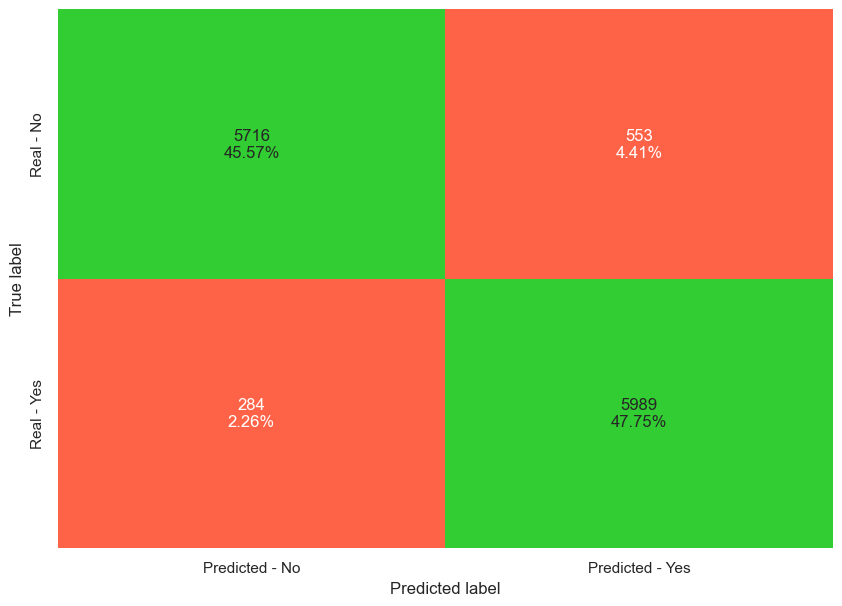

In [73]:
dt = DecisionTreeClassifier(random_state=1)

inicio_dt = time() 

dt.fit(X_train,y_train)

final_dt = time() 

#Calculating different metrics
obtener_metricas('Decision Tree',dt,inicio_dt,final_dt)

#Creating confusion matrix
matriz_de_confusion(dt,y_test)

#### Poda del Decision Tree (Cost Complexity Pruning)

En este punto validamos si reducir el número de hojas mejora el rendimiento del modelo

In [74]:
path = dt.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas, impurities = path.ccp_alphas, path.impurities

In [75]:
clfs_list = []

inicio_dtp = time()

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=1, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs_list.append(clf)

print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs_list[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.06825867499802885


In [76]:
#Fitting model for each value of alpha and saving the train recall in a list
precision_train=[]
for clf in clfs_list:
    pred_train=clf.predict(X_train)
    values_train=metrics.precision_score(y_train,pred_train)
    precision_train.append(values_train)

C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [77]:
#Fitting model for each value of alpha and saving the test recall in a list
precision_test=[]
for clf in clfs_list:
    pred_test=clf.predict(X_test)
    values_test=metrics.precision_score(y_test,pred_test)
    precision_test.append(values_test)

C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


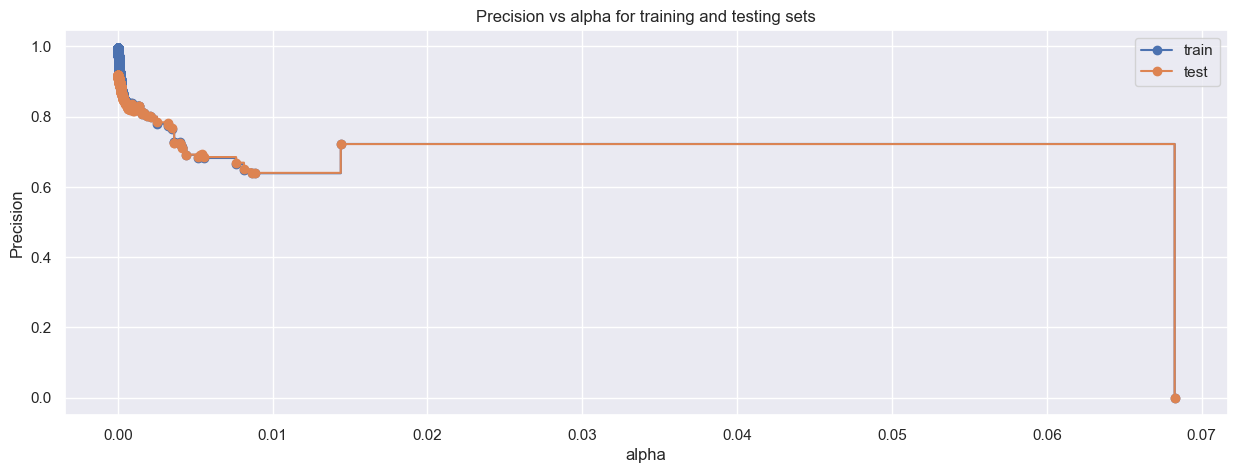

In [78]:
#Plotting the graph for Recall VS alpha
fig, ax = plt.subplots(figsize=(15,5))
ax.set_xlabel("alpha")
ax.set_ylabel("Precision")
ax.set_title("Precision vs alpha for training and testing sets")
ax.plot(ccp_alphas, precision_train, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, precision_test, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

Aquí se puede ver que el alpha disminuye apenas deja de ser 0.00, lo que implicaría es que no deberíamos modificar este hiperparámetro.

Exactitud (Accuracy) en dataset de entrenamiento :  0.9912862219792237
Exactitud (Accuracy) en dataset de prueba :  0.9322277148780099
Sensibilidad (Recall) en dataset de entrenamiento :  0.9882433356117567
Sensibilidad (Recall) en dataset de prueba :  0.9493065518890483
Precisión (Precision) en dataset de entrenamiento :  0.9942920019255898
Precisión (Precision) en dataset de prueba :  0.9179898258054571
Promedio de Validación Cruzada :  0.9263261188711025
Tiempo de cómputo (en segundos) :  177.85
Tiempo de cómputo (en minutos) :  2.96


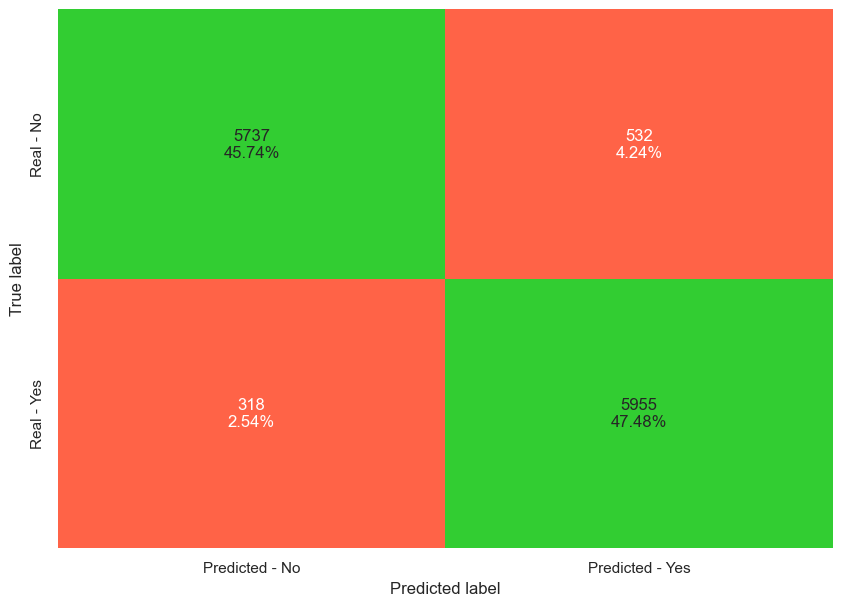

In [79]:
# Creando el modelo con la mejor precision posible
index_best_pruned_model = np.argmax(precision_test)

dt_pruned = clfs_list[index_best_pruned_model]

final_dtp = time() 

#Calculating different metrics
obtener_metricas('Decision Tree Pruned',dt_pruned,inicio_dtp,final_dtp)

matriz_de_confusion(dt_pruned,y_test)

### 6.3.3. Random Forest

Exactitud (Accuracy) en dataset de entrenamiento :  0.9937465828321487
Exactitud (Accuracy) en dataset de prueba :  0.9423536915962366
Sensibilidad (Recall) en dataset de entrenamiento :  0.9926862611073137
Sensibilidad (Recall) en dataset de prueba :  0.9595090068547745
Precisión (Precision) en dataset de entrenamiento :  0.9947941639838345
Precisión (Precision) en dataset de prueba :  0.9277127003699137
Promedio de Validación Cruzada :  0.9372607932860435
Tiempo de cómputo (en segundos) :  2.31
Tiempo de cómputo (en minutos) :  0.04


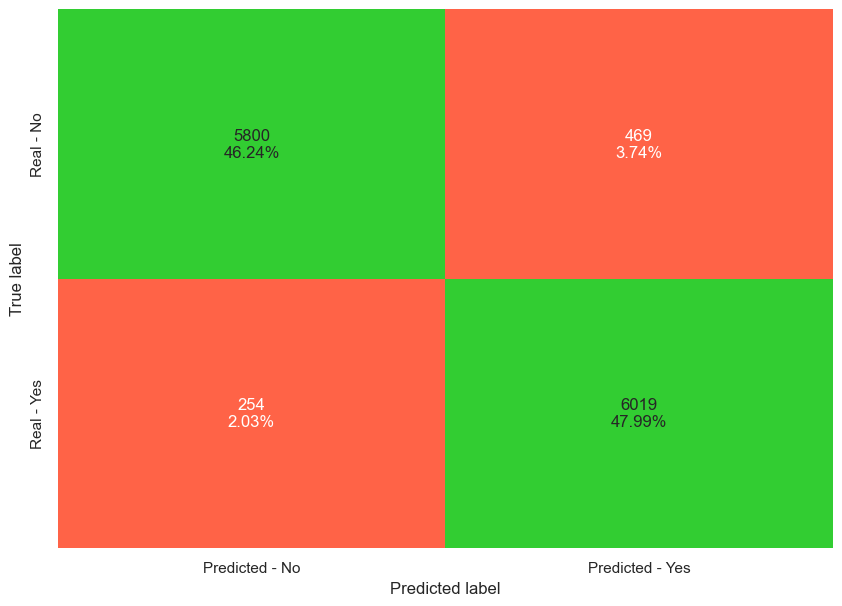

In [80]:
rf = RandomForestClassifier(random_state=1)

inicio_rf = time() 

rf.fit(X_train,y_train)

final_rf = time() 

#Calculating different metrics
obtener_metricas('Random Forest',rf,inicio_rf,final_rf)

#Creating confusion matrix
matriz_de_confusion(rf,y_test)

### 6.3.4. Bagging Classifier

Exactitud (Accuracy) en dataset de entrenamiento :  0.9898168398031711
Exactitud (Accuracy) en dataset de prueba :  0.9354967309838941
Sensibilidad (Recall) en dataset de entrenamiento :  0.9886534518113466
Sensibilidad (Recall) en dataset de prueba :  0.9494659652478877
Precisión (Precision) en dataset de entrenamiento :  0.9909564264181968
Precisión (Precision) en dataset de prueba :  0.923697270471464
Promedio de Validación Cruzada :  0.9309391553530861
Tiempo de cómputo (en segundos) :  0.66
Tiempo de cómputo (en minutos) :  0.01


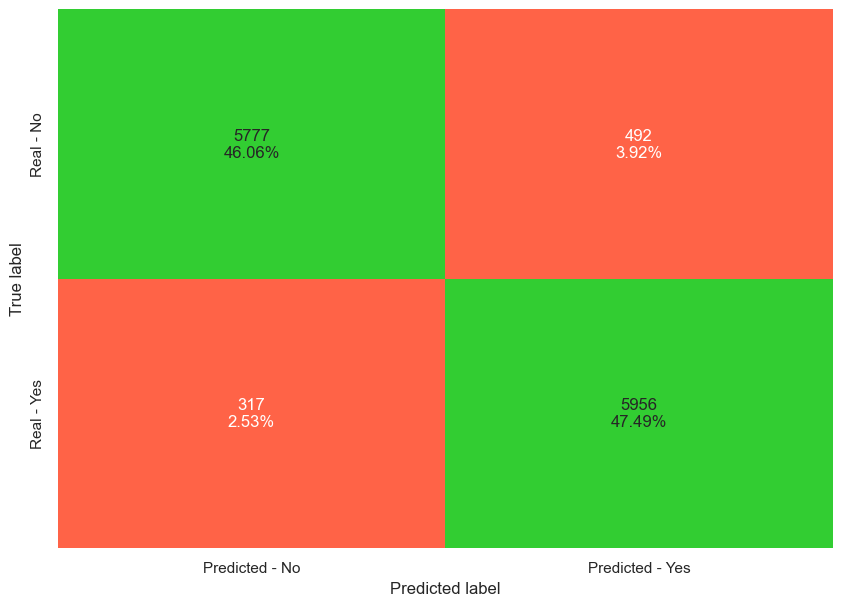

In [81]:
bag = BaggingClassifier(random_state=1)

inicio_bag = time() 

bag.fit(X_train,y_train)

final_bag = time() 

#Calculating different metrics
obtener_metricas('Bagging Classifier',bag,inicio_bag,final_bag)

#Creating confusion matrix
matriz_de_confusion(bag,y_test)

### 6.3.5. Adaboost Classifier

C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

Exactitud (Accuracy) en dataset de entrenamiento :  0.7776790595954073
Exactitud (Accuracy) en dataset de prueba :  0.7735608355924095
Sensibilidad (Recall) en dataset de entrenamiento :  0.7966507177033493
Sensibilidad (Recall) en dataset de prueba :  0.7839948987725172
Precisión (Precision) en dataset de entrenamiento :  0.7674832082180956
Precisión (Precision) en dataset de prueba :  0.7680774636888958
Promedio de Validación Cruzada :  0.7743641990209202
Tiempo de cómputo (en segundos) :  1.08
Tiempo de cómputo (en minutos) :  0.02


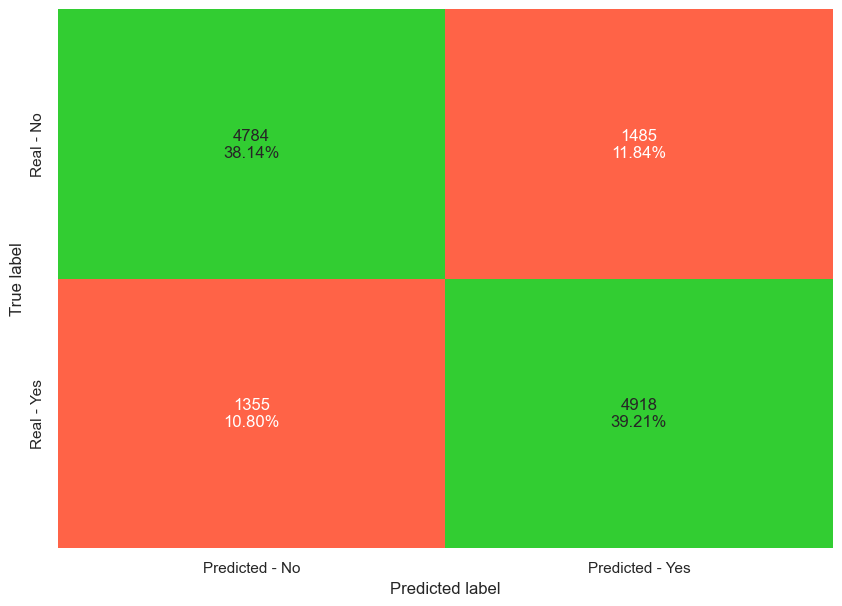

In [82]:
ab = AdaBoostClassifier(random_state=1)

inicio_ab = time() 

ab.fit(X_train,y_train)

final_ab = time() 

#Calculating different metrics
obtener_metricas('Adaboost Classifier',ab,inicio_ab,final_ab)

#Creating confusion matrix
matriz_de_confusion(ab,y_test)

### 6.3.6. Gradient Boost

Exactitud (Accuracy) en dataset de entrenamiento :  0.8241867140513942
Exactitud (Accuracy) en dataset de prueba :  0.8191675968745017
Sensibilidad (Recall) en dataset de entrenamiento :  0.8488038277511962
Sensibilidad (Recall) en dataset de prueba :  0.8410648812370477
Precisión (Precision) en dataset de entrenamiento :  0.808937528499772
Precisión (Precision) en dataset de prueba :  0.8058652818084618
Promedio de Validación Cruzada :  0.8197443307724136
Tiempo de cómputo (en segundos) :  2.39
Tiempo de cómputo (en minutos) :  0.04


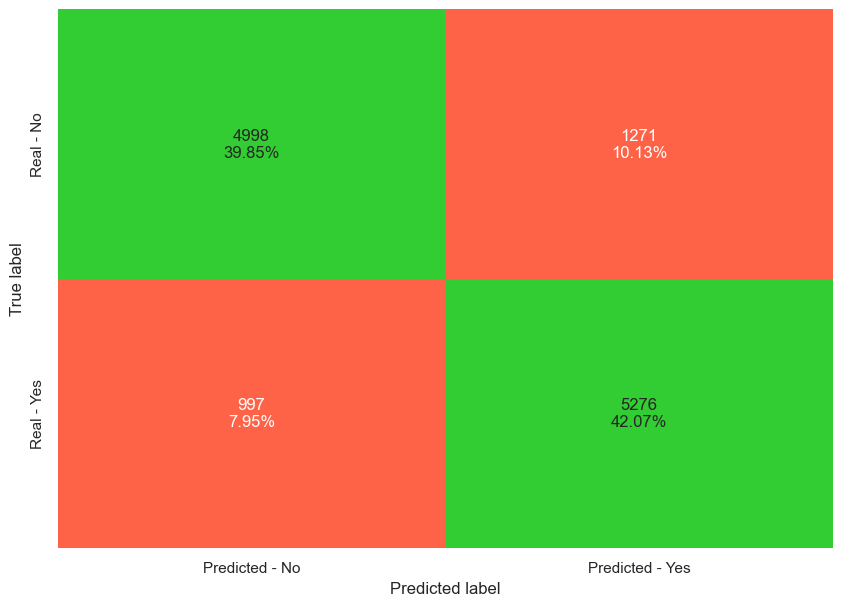

In [83]:
#Fitting the model
gb = GradientBoostingClassifier(random_state=1)

inicio_gb = time() 

gb.fit(X_train,y_train)

final_gb = time() 

#Calculating different metrics
obtener_metricas('Gradient Boost',gb,inicio_gb,final_gb)

#Creating confusion matrix
matriz_de_confusion(gb,y_test)

### 6.3.7. XGBoost

Exactitud (Accuracy) en dataset de entrenamiento :  0.9300164024056862
Exactitud (Accuracy) en dataset de prueba :  0.9055971934300749
Sensibilidad (Recall) en dataset de entrenamiento :  0.9415584415584416
Sensibilidad (Recall) en dataset de prueba :  0.9172644667623147
Precisión (Precision) en dataset de entrenamiento :  0.9202966328166756
Precisión (Precision) en dataset de prueba :  0.8964013086150491
Promedio de Validación Cruzada :  0.906335499995971
Tiempo de cómputo (en segundos) :  0.17
Tiempo de cómputo (en minutos) :  0.0


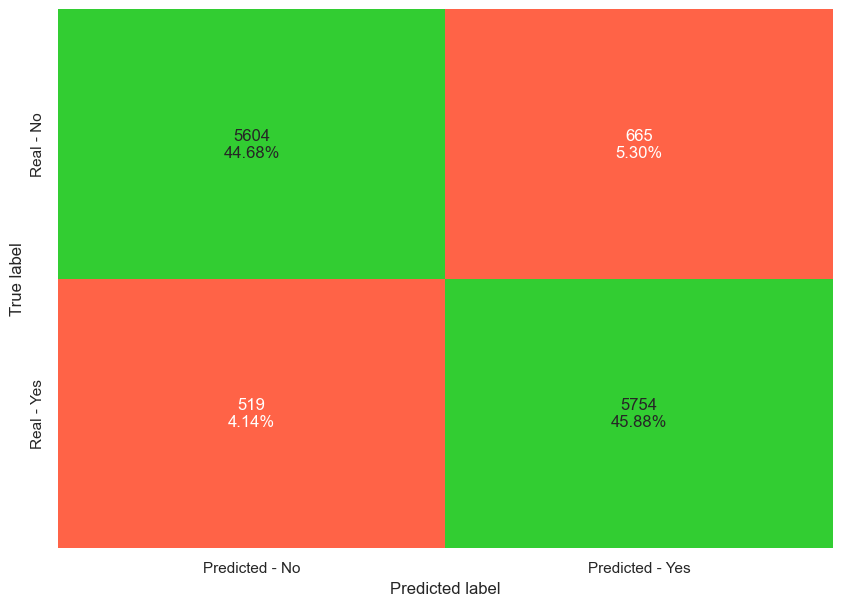

In [84]:
#Fitting the model
xgb = XGBClassifier(random_state=1)

inicio_xgb = time() 

xgb.fit(X_train,y_train)

final_xgb = time() 

#Calculating different metrics
obtener_metricas('XGBoost',xgb,inicio_xgb,final_xgb)

#Creating confusion matrix
matriz_de_confusion(xgb,y_test)

### 6.3.8. Stacking Classifier

In [101]:
estimators = [('Random Forest',rf), ('Bagging Classifier',bag), ('Decision Tree',dt)]

final_estimator = ab

inicio_st = time() 

st = StackingClassifier(estimators=estimators,final_estimator=final_estimator)

st.fit(X_train,y_train)

final_st = time() 

C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
C:\Users\aperalesc\AppData\Local\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

Exactitud (Accuracy) en dataset de entrenamiento :  0.9926530891197376
Exactitud (Accuracy) en dataset de prueba :  0.9418752989953756
Sensibilidad (Recall) en dataset de entrenamiento :  0.9885850991114149
Sensibilidad (Recall) en dataset de prueba :  0.9438864976885063
Precisión (Precision) en dataset de entrenamiento :  0.9966921645648129
Precisión (Precision) en dataset de prueba :  0.9401397268974278
Promedio de Validación Cruzada :  0.9385593135721276
Tiempo de cómputo (en segundos) :  19.34
Tiempo de cómputo (en minutos) :  0.32


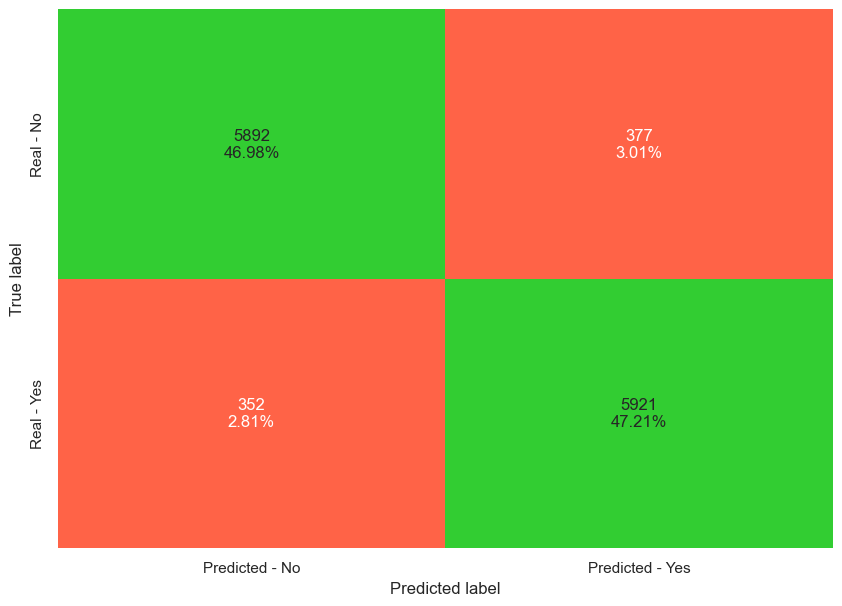

In [102]:
#Calculating different metrics
obtener_metricas('Stacking Classifier',st,inicio_st,final_st)

#Creating confusion matrix
matriz_de_confusion(st,y_test)

## 6.4. Ajuste de Hiperparámetros

### 6.4.1. Decision Tree

Exactitud (Accuracy) en dataset de entrenamiento :  0.681656642974303
Exactitud (Accuracy) en dataset de prueba :  0.6825865093286557
Sensibilidad (Recall) en dataset de entrenamiento :  0.5904989747095011
Sensibilidad (Recall) en dataset de prueba :  0.5946118284712258
Precisión (Precision) en dataset de entrenamiento :  0.7220829154129054
Precisión (Precision) en dataset de prueba :  0.721749226006192
Promedio de Validación Cruzada :  0.6816567711156181
Tiempo de cómputo (en segundos) :  246.06
Tiempo de cómputo (en minutos) :  4.1


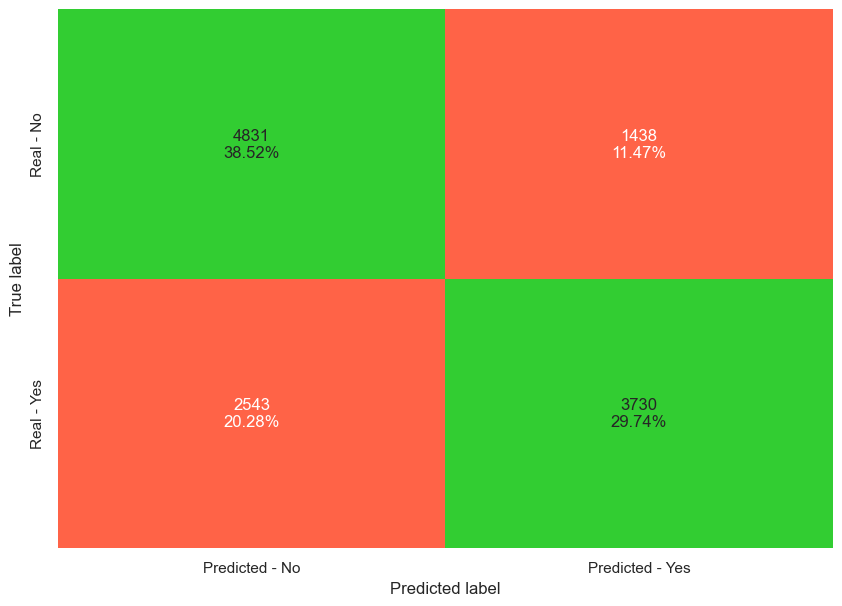

In [89]:
# Definimos parámetros a utilizar
parametros_dt = {'max_depth': np.arange(2,30),
              'min_samples_leaf': [1, 2, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10,15],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Utlimizar métrica de precisión
scorer = metrics.make_scorer(metrics.precision_score)

inicio_dt_tuned = time() 

# Búsqueda de los mejores parámetros
grid_obj = GridSearchCV(dt, parametros_dt, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Usar los mejores estimadores
dt_tuned = grid_obj.best_estimator_

# Entrenar el modelo
dt_tuned.fit(X_train, y_train)

final_dt_tuned = time() 

obtener_metricas('Decision Tree Tuned',dt_tuned,inicio_dt_tuned,final_dt_tuned)

matriz_de_confusion(dt_tuned,y_test)

### 6.4.2. Random Forest

Exactitud (Accuracy) en dataset de entrenamiento :  0.9340486604702023
Exactitud (Accuracy) en dataset de prueba :  0.9073512996332324
Sensibilidad (Recall) en dataset de entrenamiento :  0.9342447026657553
Sensibilidad (Recall) en dataset de prueba :  0.9088155587438227
Precisión (Precision) en dataset de entrenamiento :  0.9338617108499591
Precisión (Precision) en dataset de prueba :  0.9062152281036401
Promedio de Validación Cruzada :  0.9097524401376678
Tiempo de cómputo (en segundos) :  4268.53
Tiempo de cómputo (en minutos) :  71.14


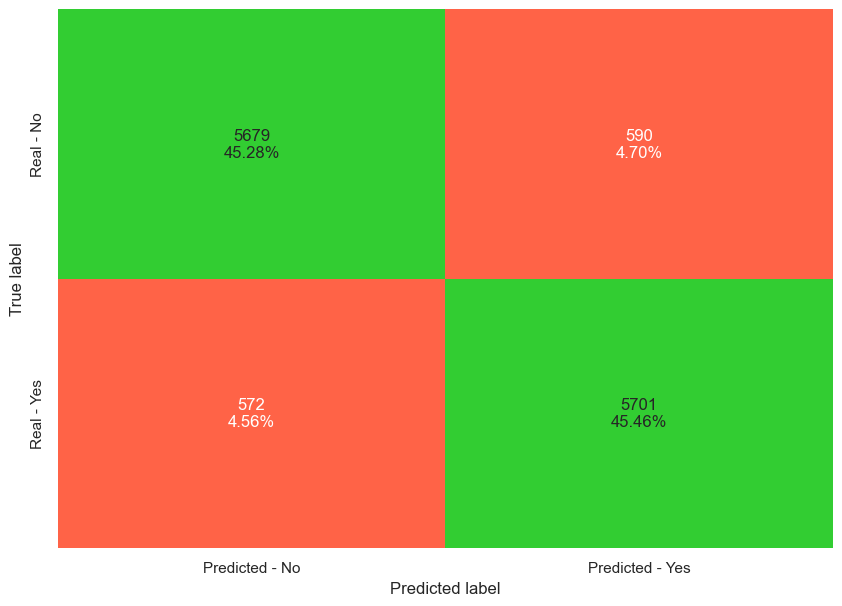

In [90]:
# Definimos parámetros a utilizar
parametros_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': np.arange(5, 20, 5),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Utlimizar métrica de precisión
scorer = metrics.make_scorer(metrics.precision_score)

inicio_rf_tuned = time() 

# Búsqueda de los mejores parámetros
grid_obj = GridSearchCV(rf, parametros_rf, scoring=scorer,n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Usar los mejores estimadores
rf_tuned = grid_obj.best_estimator_

# Entrenar el modelo
rf_tuned.fit(X_train, y_train)

final_rf_tuned = time() 

obtener_metricas('Random Forest Tuned',rf_tuned,inicio_rf_tuned,final_rf_tuned)

matriz_de_confusion(rf_tuned,y_test)

# 7. Evaluación del Mejor Modelo

## 7.1. Comparación de Métricas

In [103]:
df_metrics.sort_values(by=['Precision_test'],ascending=False)

,Model,Accuracy_train,Accuracy_test,Recall_train,Recall_test,Precision_train,Precision_test,CV_Mean_Score,Time_Sec,Time_Min
10,Stacking Classifier,0.992653,0.941875,0.988585,0.943886,0.996692,0.940140,0.938559,19.34,0.32
3,Random Forest,0.993747,0.942354,0.992686,0.959509,0.994794,0.927713,0.937261,2.31,0.04
4,Bagging Classifier,0.989817,0.935497,0.988653,0.949466,0.990956,0.923697,0.930939,0.66,0.01
2,Decision Tree Pruned,0.991286,0.932228,0.988243,0.949307,0.994292,0.917990,0.926326,177.85,2.96
1,Decision Tree,0.993747,0.933264,0.991661,0.954727,0.995813,0.915469,0.926121,0.14,0.00
9,Random Forest Tuned,0.934049,0.907351,0.934245,0.908816,0.933862,0.906215,0.909752,4268.53,71.14
7,XGBoost,0.930016,0.905597,0.941558,0.917264,0.920297,0.896401,0.906335,0.17,0.00
6,Gradient Boost,0.824187,0.819168,0.848804,0.841065,0.808938,0.805865,0.819744,2.39,0.04
5,Adaboost Classifier,0.777679,0.773561,0.796651,0.783995,0.767483,0.768077,0.774364,1.08,0.02
0,Regresión Logística,0.727788,0.726838,0.732126,0.726287,0.725776,0.727215,0.727037,1.59,0.03


En la comparación de todos los modelos basados en la Precisión, se ve que el mejor modelo es el **Stacking Classifier**, seguido del **Random Forest**

## 7.2. AUC - Area Bajo la Curva

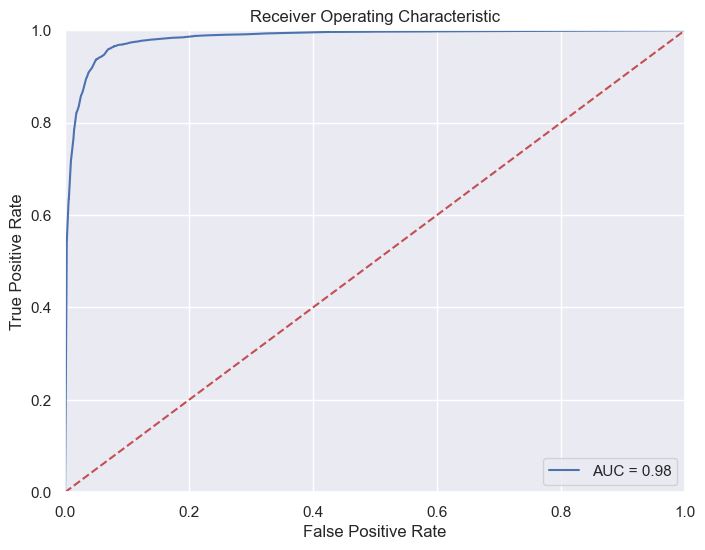

In [92]:
#AUC ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Identificar el AUC del mejor predictor
probs = st.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

El resultado de nuestra evaluación AUC es de **0.98**, lo que indica una excelente capacidad del modelo para distinguir entre clases positivas y negativas.

- Un valor de 1 significa que el modelo clasifica perfectamente ambas clases.
- Un valor de 0.5 indica que el modelo no tiene capacidad de discriminación y actúa como si fuera al azar, como lanzar una moneda.
- Un valor inferior a 0.5 indica que el modelo clasifica peor que al azar, confundiendo más de lo que acierta.

## 7.3. Identificación de los mejores Estimadores

Para este caso en particular, vamos a tomar el Random Forest, el cual es el mejor modelo por debajo del Stacking Classifier.

No tomamos este último debido a que no se pueden identificar el peso de los estimadores de este modelo en particular.

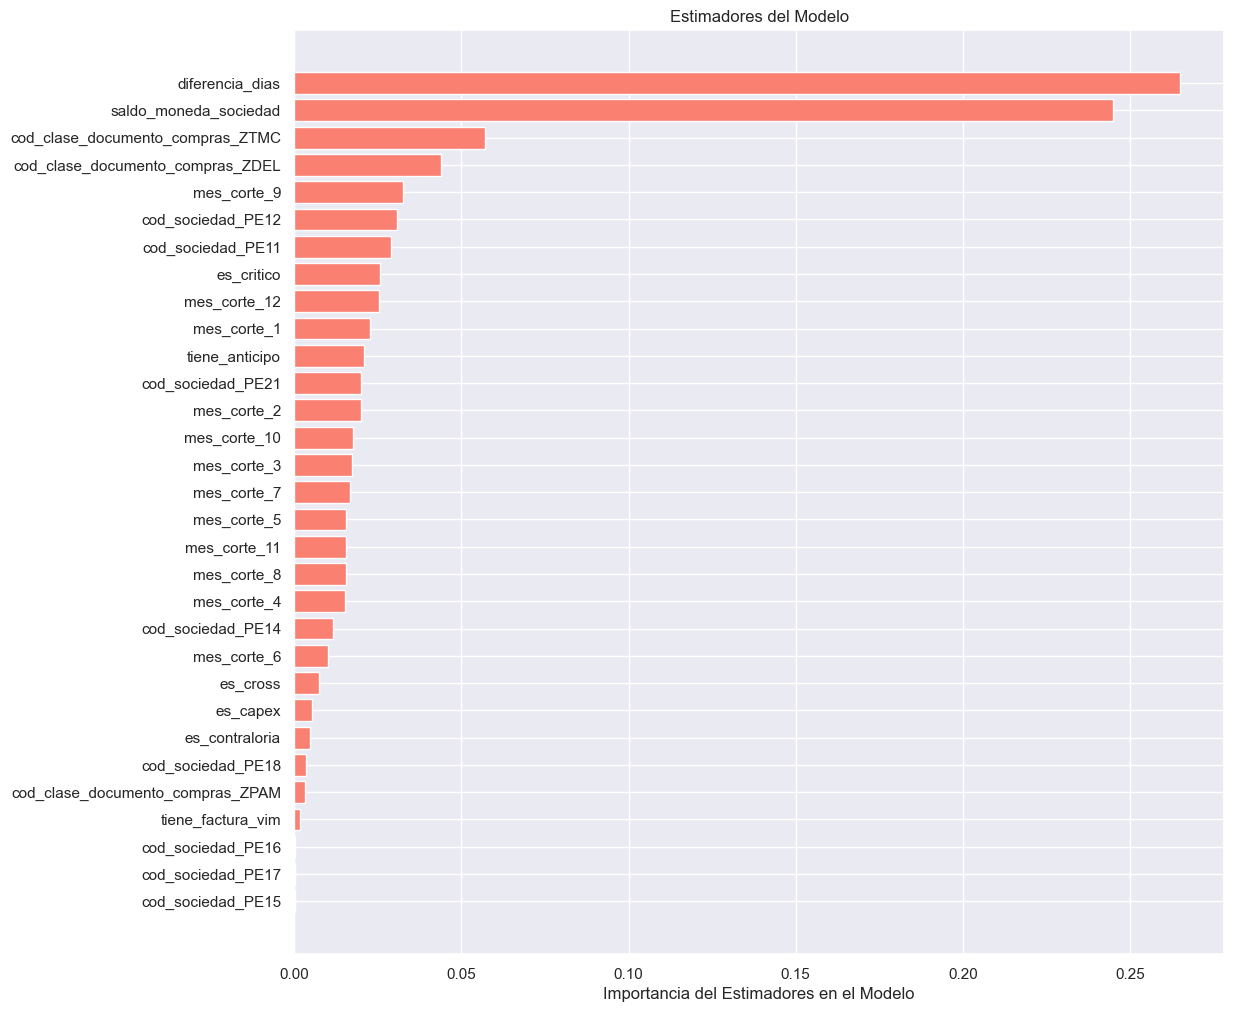

In [104]:
feature_names = X_train.columns
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Estimadores del Modelo')
plt.barh(range(len(indices)), importances[indices], color='salmon', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importancia del Estimadores en el Modelo')
plt.show()

# 8. Predicciones con Dataset del Periodo Actual

In [105]:
# Predice los valores para test_dummies
test_dummies_predict = test_dummies.drop(columns=['extornado'])

In [106]:
train_dummies_predict = train_dummies.drop(columns=['extornado'])

In [107]:
test_dummies_predict = test_dummies_predict[train_dummies_predict.columns]

## 8.1. Generando Predicciones

In [108]:
# Predice los valores de test_dummies
predicciones_test = st.predict(test_dummies_predict)

[0. 0. 0. ... 0. 0. 0.]


In [109]:
# Crea un nuevo DataFrame con las columnas deseadas
resultados = pd.DataFrame({
    'cod_periodo': test_og['cod_periodo'],
    'cod_documento_compras': test_og['cod_documento_compras'],
    'posicion': test_og['posicion'],
    'cod_sociedad': test_og['cod_sociedad'],
    'cod_clase_documento_compras': test_og['cod_clase_documento_compras'],
    'fecha_vencimiento': test_og['fecha_vencimiento'],
    'predicciones': predicciones_test  # Añade las predicciones
})

In [111]:
resultados.to_csv('resultados_ajuste_partidas.csv',index=False)